# Implicit Kernel Decoder-only transformer experiments

This notebook contains experiments of Implicit Kernel attention decoder-only transformer applied in the context of timeseries forecasting. In this notebook, you will find the following experiments:
- **Experiment 1**: 1-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 2**: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 3**: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target
- **Experiment 4**: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series
- **Experiment 5**: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target
- **Experiment 6**: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target
- **Experiment 7**: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

For visualization and inspection purposes, we use 3 decoder layers and a single attention head

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import src.Datasets.SyntheticDataset as SD
from src.Transformer.DecoderOnly import PointDecoderOnlyTransformer
from src.Transformer.KernelAttention import ImplicitKernelAttention
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

ES = EarlyStopping(patience=30, delta=0)

In [2]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# attention module
_attention = ImplicitKernelAttention(p_norm=2, R_features=64)

# meta data to store images
FOLDER = "IK_kernel"
KERNEL_NAME = "IK"

# transformer configs
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
n_hidden = emb_size // n_heads          # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions

# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Experiment 1: one-step prediction on `SimplePeriodicDataset` with overlapping source and target

In [3]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

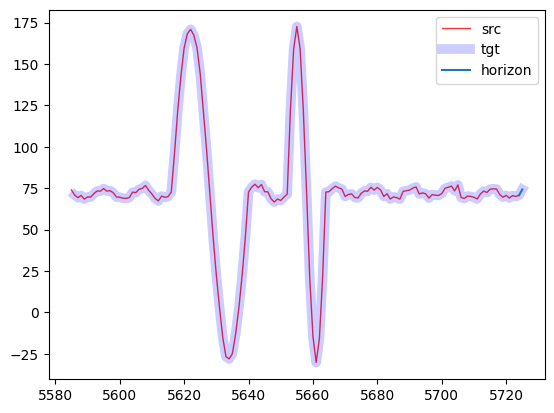

In [4]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [5]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [6]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2514.9320	val_loss=1502.1452	train_mape_loss=16.0042	val_mape_loss=18.3010	R_p=['0.2760', '0.2580']
epoch=1	train_loss=1449.9636	val_loss=1223.7218	train_mape_loss=19.8250	val_mape_loss=17.2948	R_p=['0.3138', '0.2329']
epoch=2	train_loss=779.3445	val_loss=257.1728	train_mape_loss=8.2363	val_mape_loss=2.8353	R_p=['0.1234', '0.1206']
epoch=3	train_loss=282.4429	val_loss=198.9424	train_mape_loss=3.6688	val_mape_loss=3.1252	R_p=['0.1091', '0.1030']
epoch=4	train_loss=239.2055	val_loss=194.6503	train_mape_loss=3.3364	val_mape_loss=2.6168	R_p=['0.1048', '0.1013']
epoch=5	train_loss=220.1683	val_loss=207.0666	train_mape_loss=3.5248	val_mape_loss=2.4853	R_p=['0.1101', '0.0728']
epoch=6	train_loss=209.6658	val_loss=188.7531	train_mape_loss=3.0111	val_mape_loss=2.4944	R_p=['0.0985', '0.0879']
epoch=7	train_loss=202.5160	val_loss=164.9491	train_mape_loss=3.0359	val_mape_loss=1.9525	R_p=['0.0973', '0.0682']
epoch=8	train_loss=196.2842	val_loss=165.9537	train_mape_loss=2.9128	val

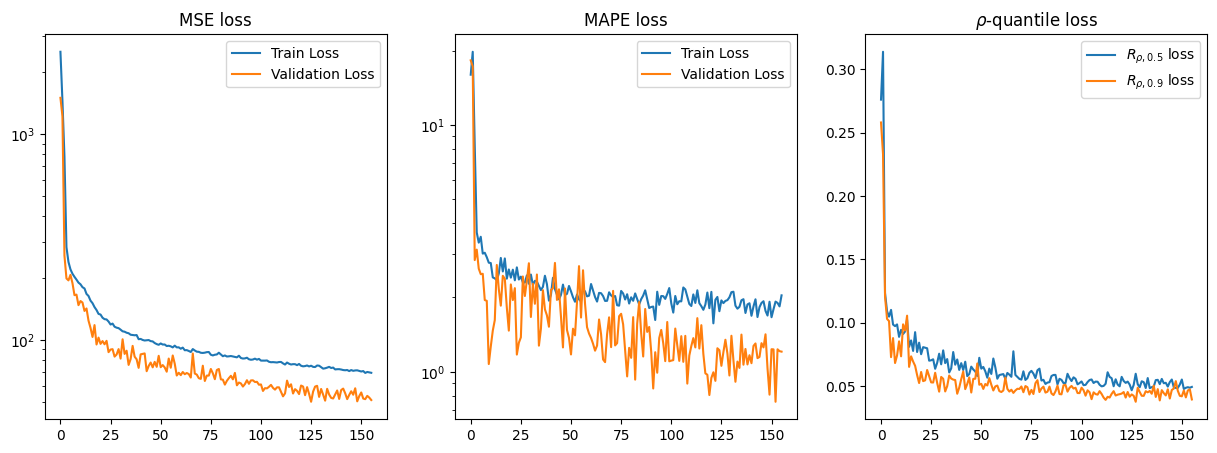

In [7]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [8]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(52.08535638427735,
 1.2364636652469636,
 [0.04927971214056015, 0.040185749530792236])

In [9]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_1pred_at_once.pth"
torch.save(best_model.state_dict(), path)

In [10]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, 0, device)

best_test_loss, best_test_mape_loss, best_r_ps

(51.788052581787106,
 1.2652733192443848,
 tensor([0.0470, 0.0445], device='cuda:0'))

### Predict

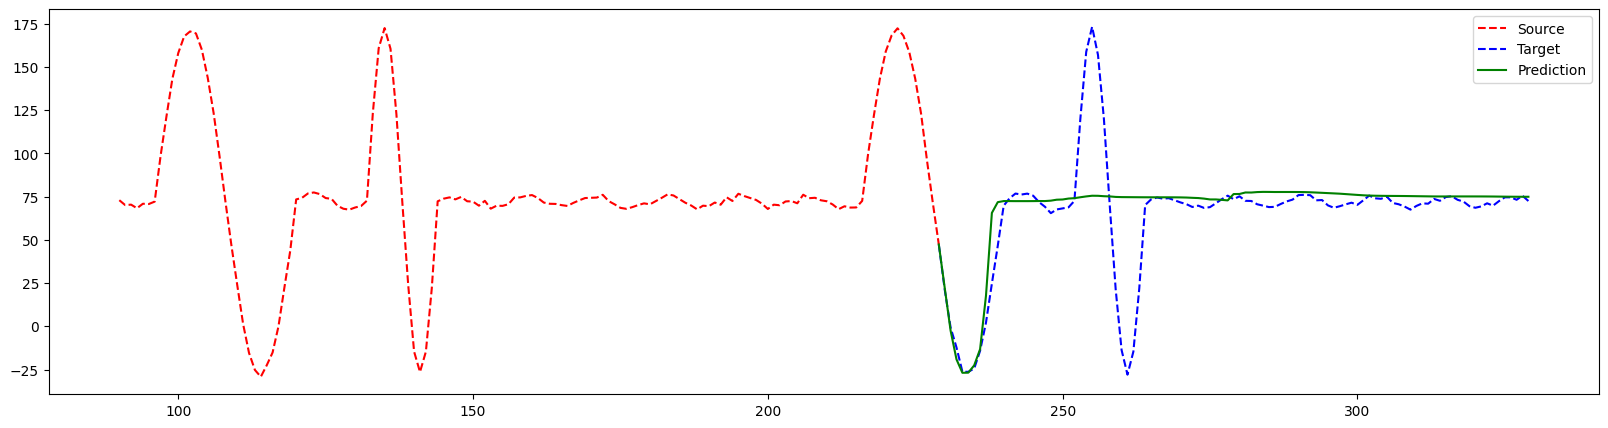

In [11]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

In [12]:
inspect_step = 0

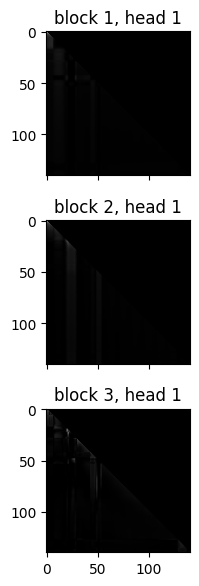

In [13]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

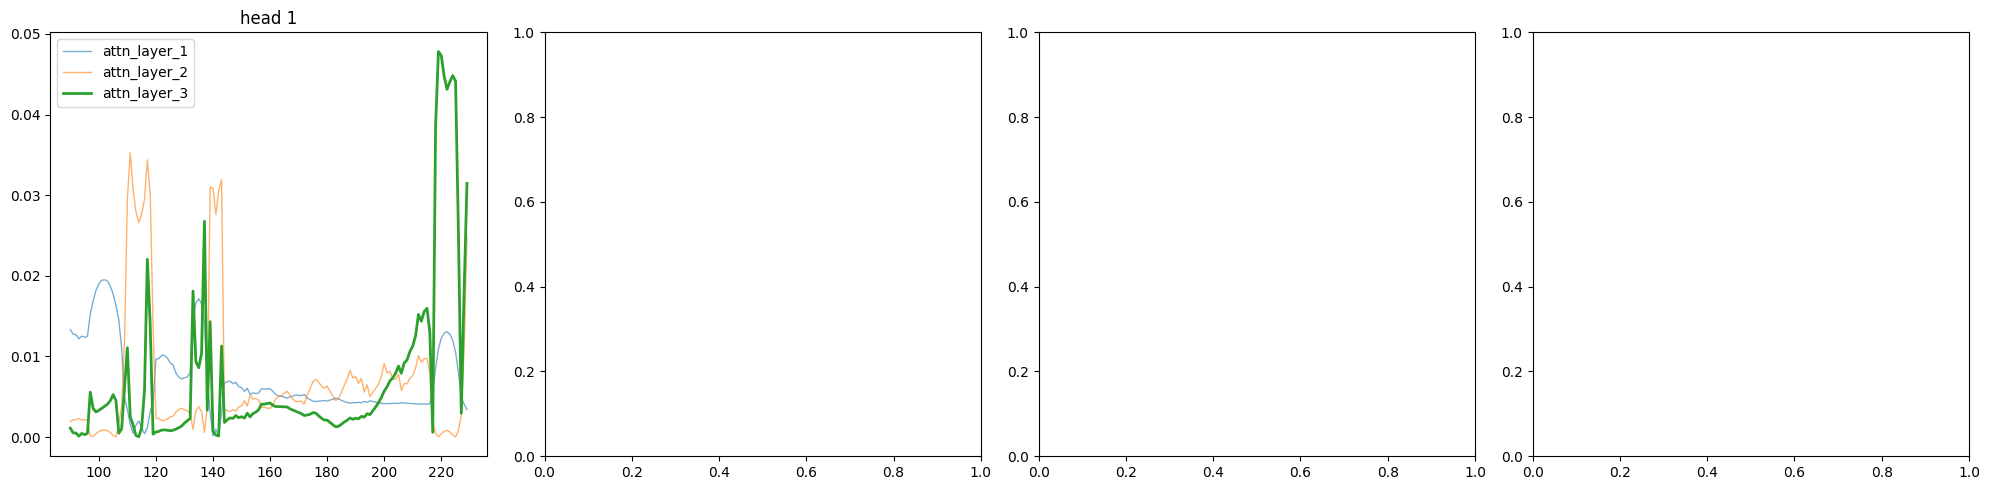

In [14]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu() # index (inspect_step, attn_layer_i, sample_0, head_j, last row, :)
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

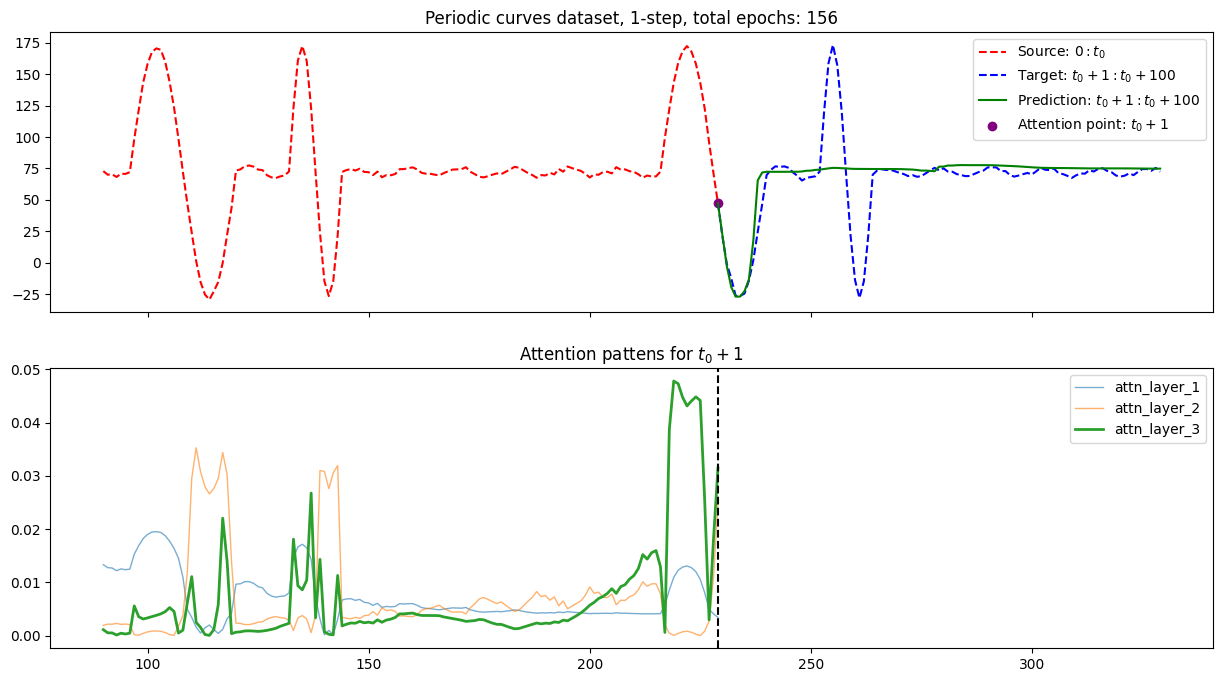

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_1pred_at_once.pdf", dpi=1200)

## Experiment 2: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target

In [16]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

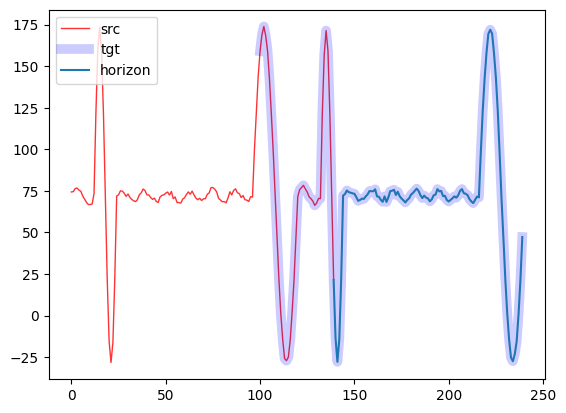

In [17]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [18]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [19]:
for epoch in range(EPOCHS):
    
    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2576.8222	val_loss=1530.2063	train_mape_loss=2.0517	val_mape_loss=2.6243	R_p=['0.2799', '0.2636']
epoch=1	train_loss=1516.0881	val_loss=1528.6874	train_mape_loss=2.4148	val_mape_loss=2.6090	R_p=['0.2786', '0.2666']
epoch=2	train_loss=1514.5908	val_loss=1526.6900	train_mape_loss=2.4148	val_mape_loss=2.6131	R_p=['0.2796', '0.2656']
epoch=3	train_loss=1502.4730	val_loss=1481.7261	train_mape_loss=2.3968	val_mape_loss=2.5859	R_p=['0.2898', '0.2685']
epoch=4	train_loss=1448.6584	val_loss=1364.4169	train_mape_loss=2.3027	val_mape_loss=2.0674	R_p=['0.2876', '0.2943']
epoch=5	train_loss=1340.4165	val_loss=1271.1115	train_mape_loss=2.0420	val_mape_loss=2.1844	R_p=['0.2866', '0.2371']
epoch=6	train_loss=1232.0486	val_loss=1206.7379	train_mape_loss=1.9264	val_mape_loss=1.8706	R_p=['0.2691', '0.2917']
epoch=7	train_loss=1136.5134	val_loss=1042.3915	train_mape_loss=1.8247	val_mape_loss=1.9033	R_p=['0.2473', '0.2412']
epoch=8	train_loss=1037.5116	val_loss=1016.2395	train_mape_loss=

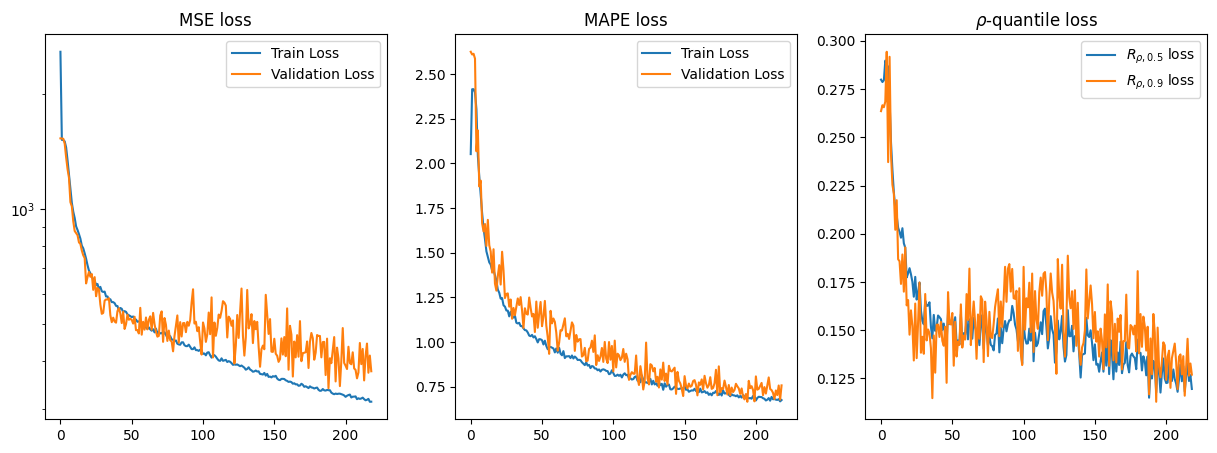

In [20]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [21]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(359.22174584960936,
 0.6405605032444001,
 [0.11508007347583771, 0.12344945967197418])

In [22]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once.pth"
torch.save(best_model.state_dict(), path)

In [23]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, 0, device)

best_test_loss, best_test_mape_loss, best_r_ps

(323.7050148925781,
 0.6309763259887695,
 tensor([0.1107, 0.1132], device='cuda:0'))

### Predict

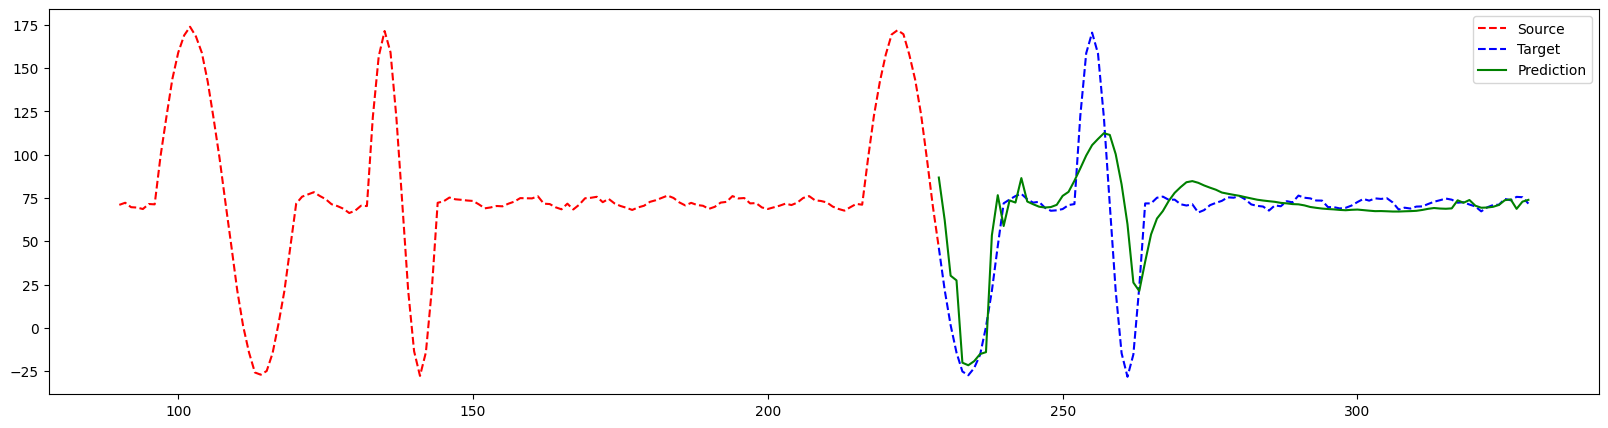

In [24]:
idx = 90
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift-1:].squeeze().cpu()
    
    tgt_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [25]:
inspect_step = 0

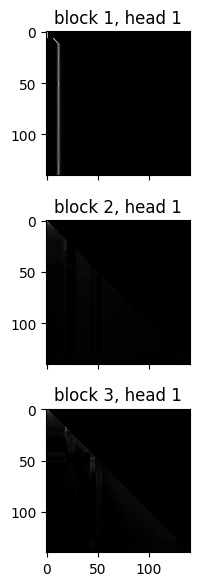

In [26]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

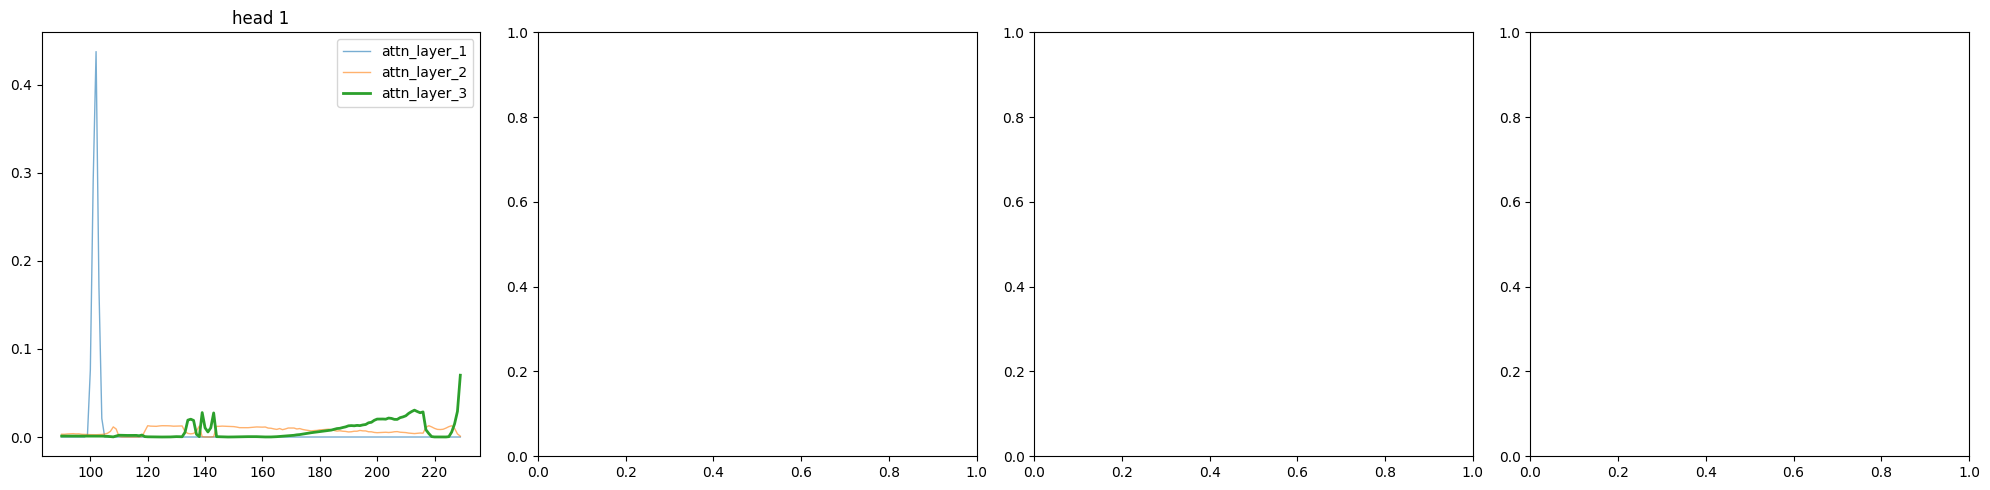

In [27]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

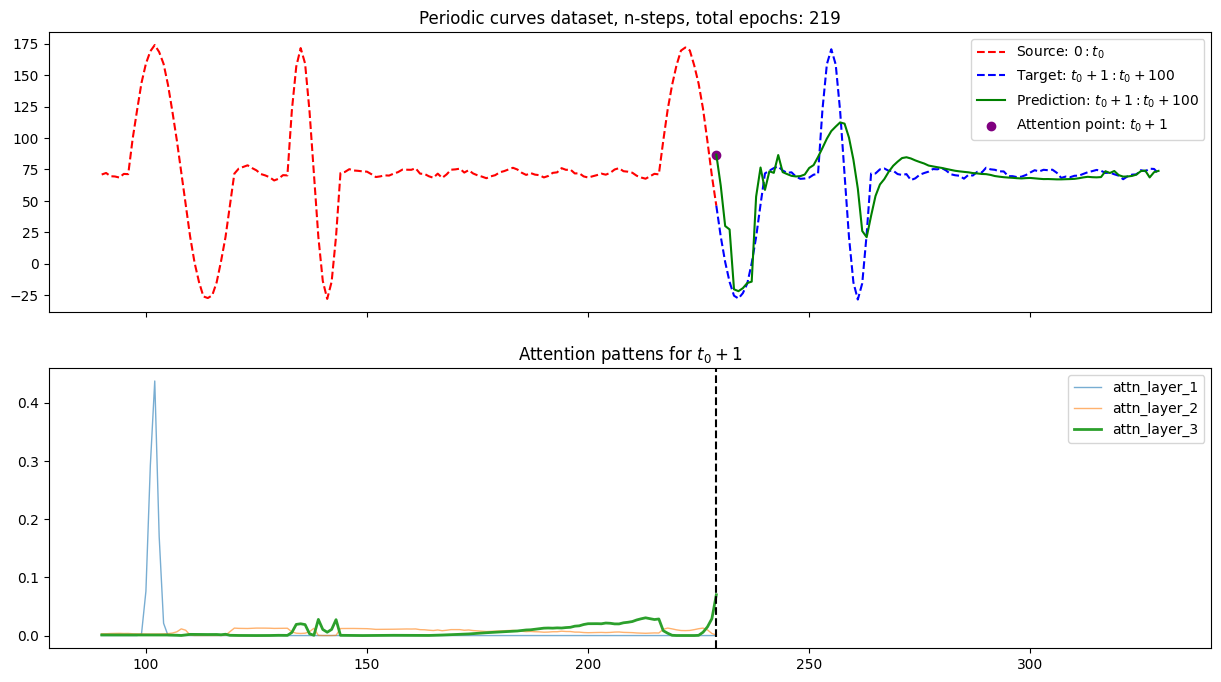

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
    ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")

ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once.pdf", dpi=1200)

## Experiment 3: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target

In [29]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

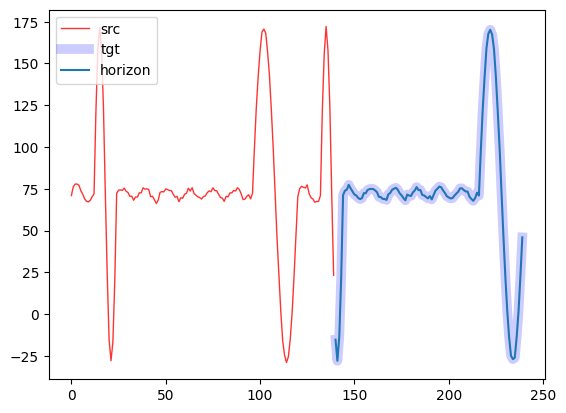

In [30]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [31]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [32]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2454.0289	val_loss=1515.0630	train_mape_loss=2.4261	val_mape_loss=2.6765	R_p=['0.2771', '0.2626']
epoch=1	train_loss=1515.5372	val_loss=1515.6581	train_mape_loss=2.8223	val_mape_loss=2.6894	R_p=['0.2783', '0.2603']
epoch=2	train_loss=1513.4425	val_loss=1497.1292	train_mape_loss=2.8178	val_mape_loss=2.6515	R_p=['0.2765', '0.2663']
epoch=3	train_loss=1468.4921	val_loss=1392.2134	train_mape_loss=2.7853	val_mape_loss=2.4255	R_p=['0.3078', '0.2616']
epoch=4	train_loss=1296.3300	val_loss=1192.1555	train_mape_loss=2.4578	val_mape_loss=2.1218	R_p=['0.2662', '0.2590']
epoch=5	train_loss=1199.7202	val_loss=1495.4955	train_mape_loss=2.2849	val_mape_loss=2.7775	R_p=['0.3021', '0.2702']
epoch=6	train_loss=1280.2872	val_loss=1156.5555	train_mape_loss=2.4605	val_mape_loss=2.1124	R_p=['0.2592', '0.2434']
epoch=7	train_loss=1158.3944	val_loss=1138.8477	train_mape_loss=2.2255	val_mape_loss=2.0895	R_p=['0.2572', '0.2543']
epoch=8	train_loss=1147.2851	val_loss=1120.1599	train_mape_loss=

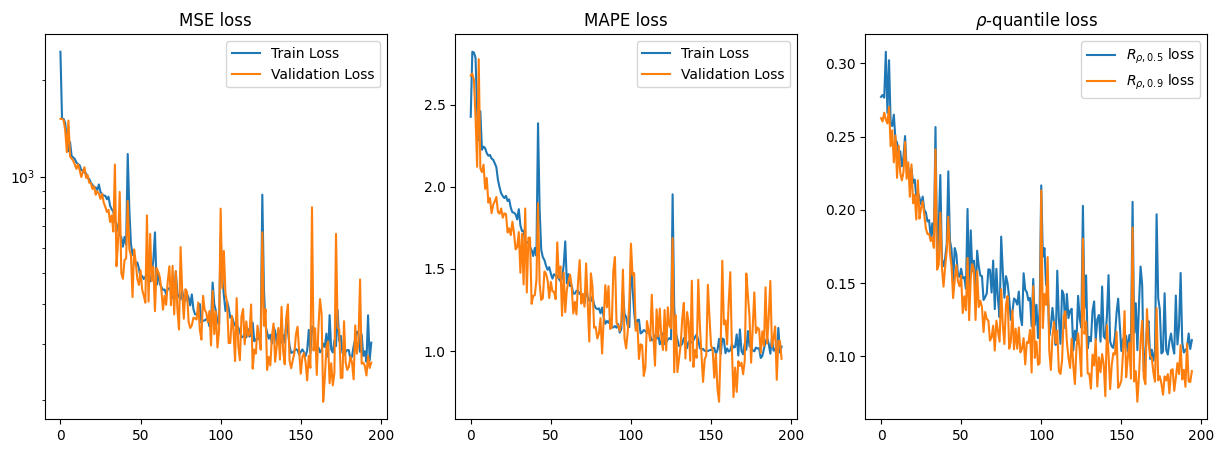

In [33]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [34]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(246.08100268554688,
 1.1316514883041382,
 [0.1075410395860672, 0.08713524043560028])

In [35]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [36]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(190.21888244628906,
 0.8565920734405518,
 tensor([0.0883, 0.0838], device='cuda:0'))

### Predict

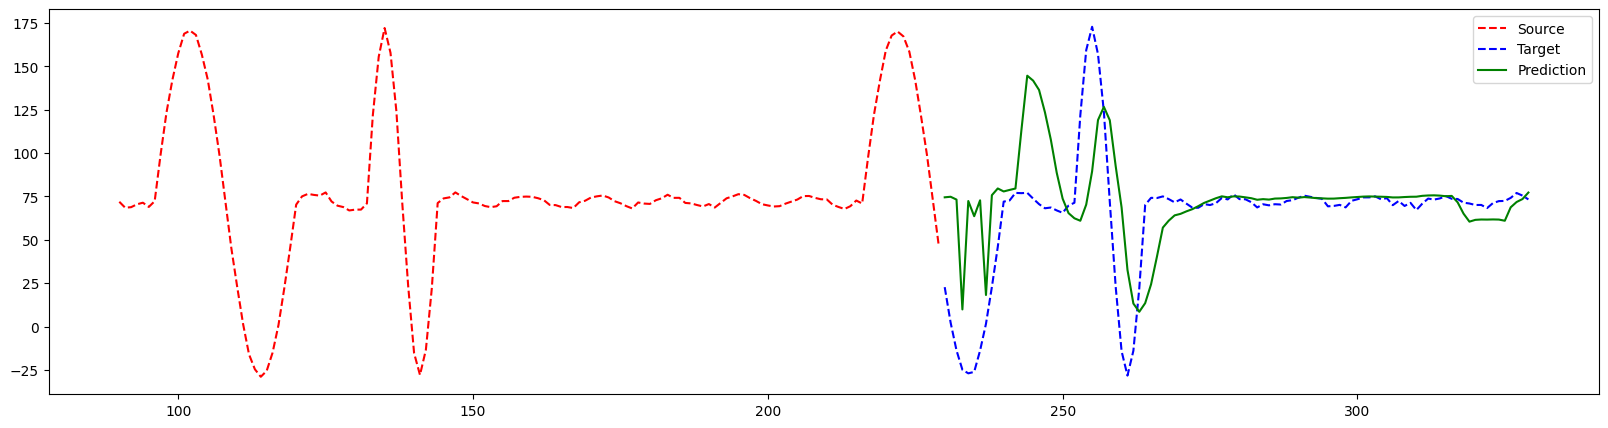

In [37]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [38]:
inspect_step = 0

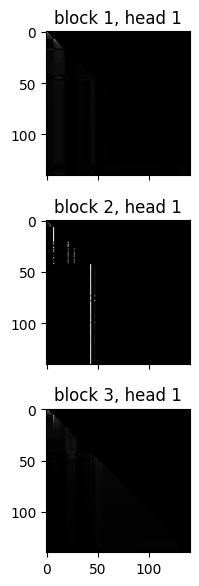

In [39]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

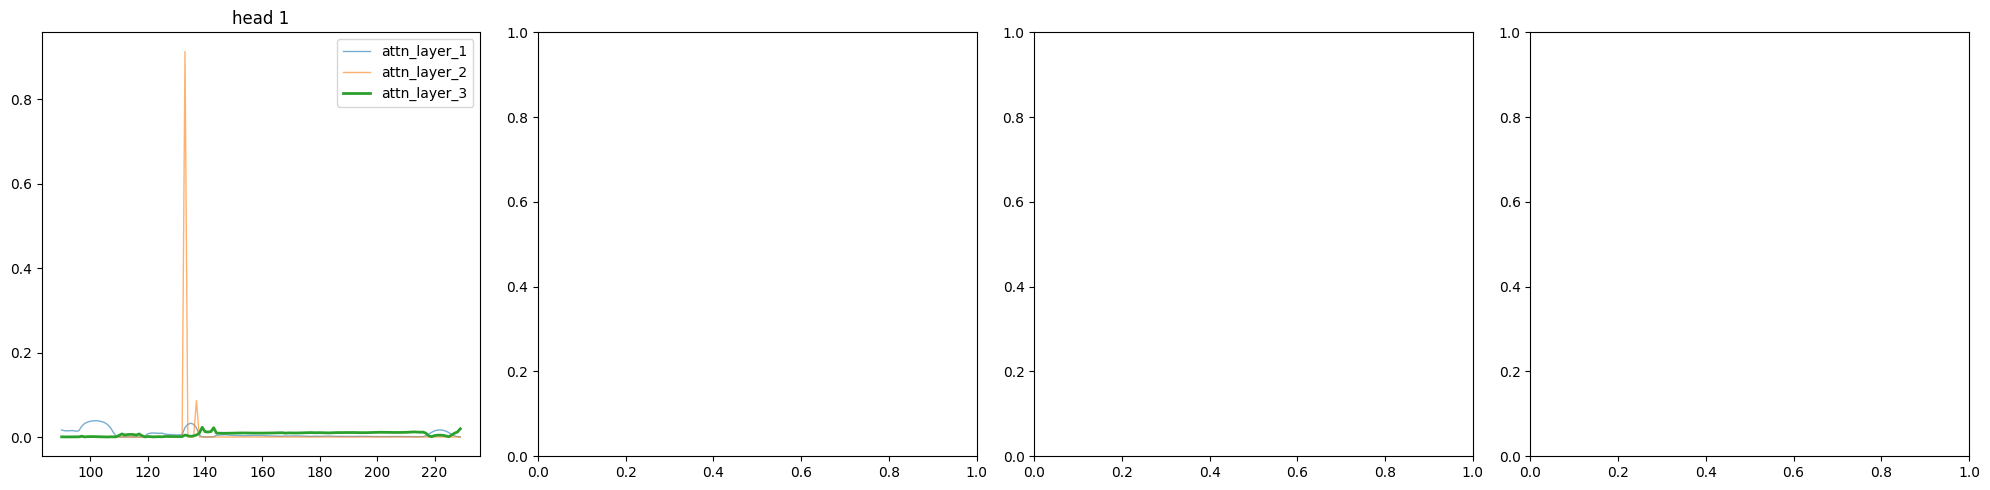

In [40]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

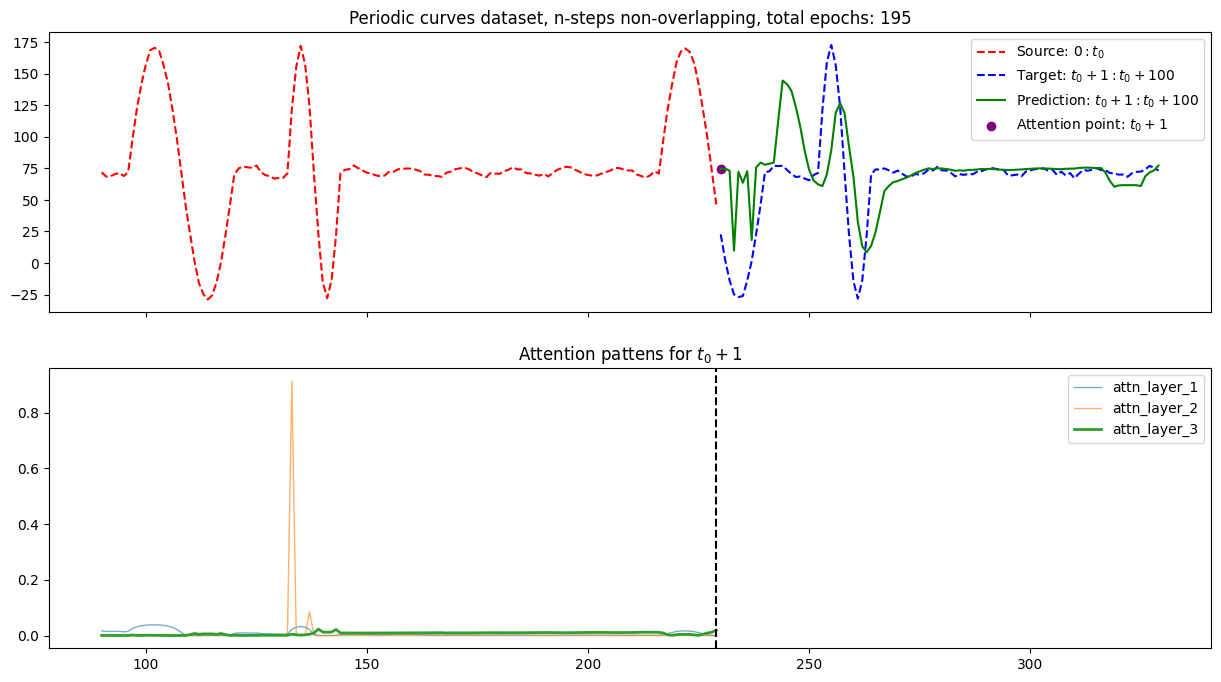

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 4: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series

In [42]:
DATASET_NAME = "multivar_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 100                      # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultivarPeriodicDataset(len_timeseries=total_length, n_timeseries=n_timeseries, seq_len=seq_len, shift=shift, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 100]),
 torch.Size([100, 1]),
 torch.Size([100, 100]))

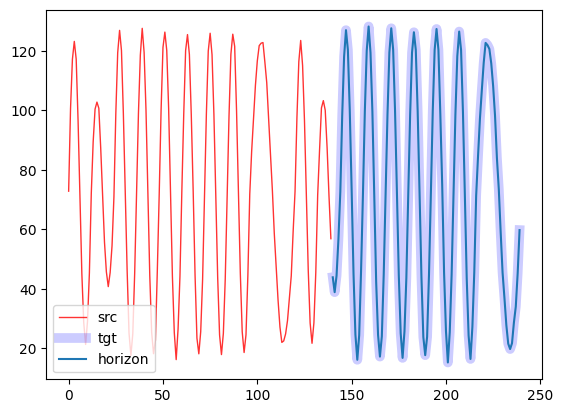

In [43]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

ith = 0 # i-th time series

plt.plot(src_X, src_fX[:, ith], 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX[:, ith], '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:, ith], tgt_fX[-shift-1:, ith], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

### Training setup

In [44]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [45]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2279.5663	val_loss=634.6912	train_mape_loss=0.5835	val_mape_loss=0.3918	R_p=['0.2730', '0.2649']
epoch=1	train_loss=668.8430	val_loss=634.6475	train_mape_loss=0.3985	val_mape_loss=0.3921	R_p=['0.2731', '0.2642']
epoch=2	train_loss=654.6384	val_loss=591.9583	train_mape_loss=0.3928	val_mape_loss=0.3717	R_p=['0.2662', '0.2768']
epoch=3	train_loss=572.6445	val_loss=518.2702	train_mape_loss=0.3679	val_mape_loss=0.3536	R_p=['0.2563', '0.2556']
epoch=4	train_loss=532.5440	val_loss=466.9698	train_mape_loss=0.3543	val_mape_loss=0.3408	R_p=['0.2438', '0.2277']
epoch=5	train_loss=462.5334	val_loss=387.4363	train_mape_loss=0.3277	val_mape_loss=0.2915	R_p=['0.2180', '0.2407']
epoch=6	train_loss=433.3080	val_loss=430.1220	train_mape_loss=0.3096	val_mape_loss=0.3167	R_p=['0.2304', '0.2193']
epoch=7	train_loss=407.1953	val_loss=339.2853	train_mape_loss=0.2957	val_mape_loss=0.2373	R_p=['0.2010', '0.2753']
epoch=8	train_loss=346.6046	val_loss=398.9248	train_mape_loss=0.2656	val_mape_l

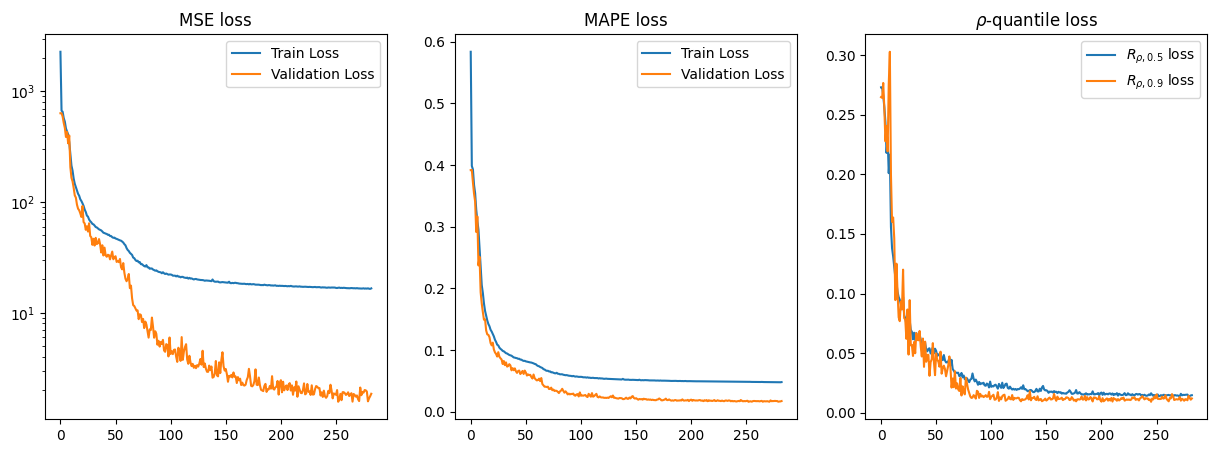

In [46]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [47]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(1.8400966510772705,
 0.017551560759544373,
 [0.014578059315681458, 0.01188307348638773])

In [48]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [49]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(1.5659619340896607,
 0.016425530090928078,
 tensor([0.0137, 0.0114], device='cuda:0'))

### Predict

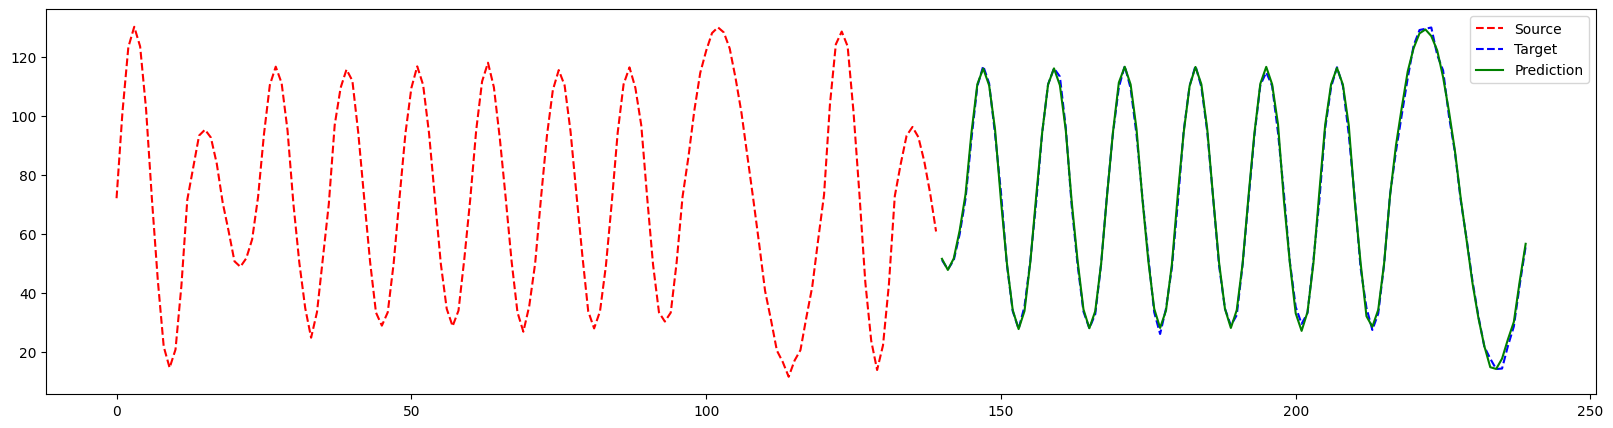

In [50]:
idx = 0 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

ith = 3

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source")
plt.plot(tgt_X, tgt_fX[:, ith], '--b', label="Target")
plt.plot(tgt_X, pred_fX[:, ith], '-g', label="Prediction")
plt.legend()

In [51]:
inspect_step = 0

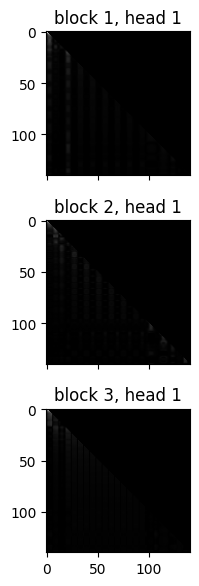

In [52]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

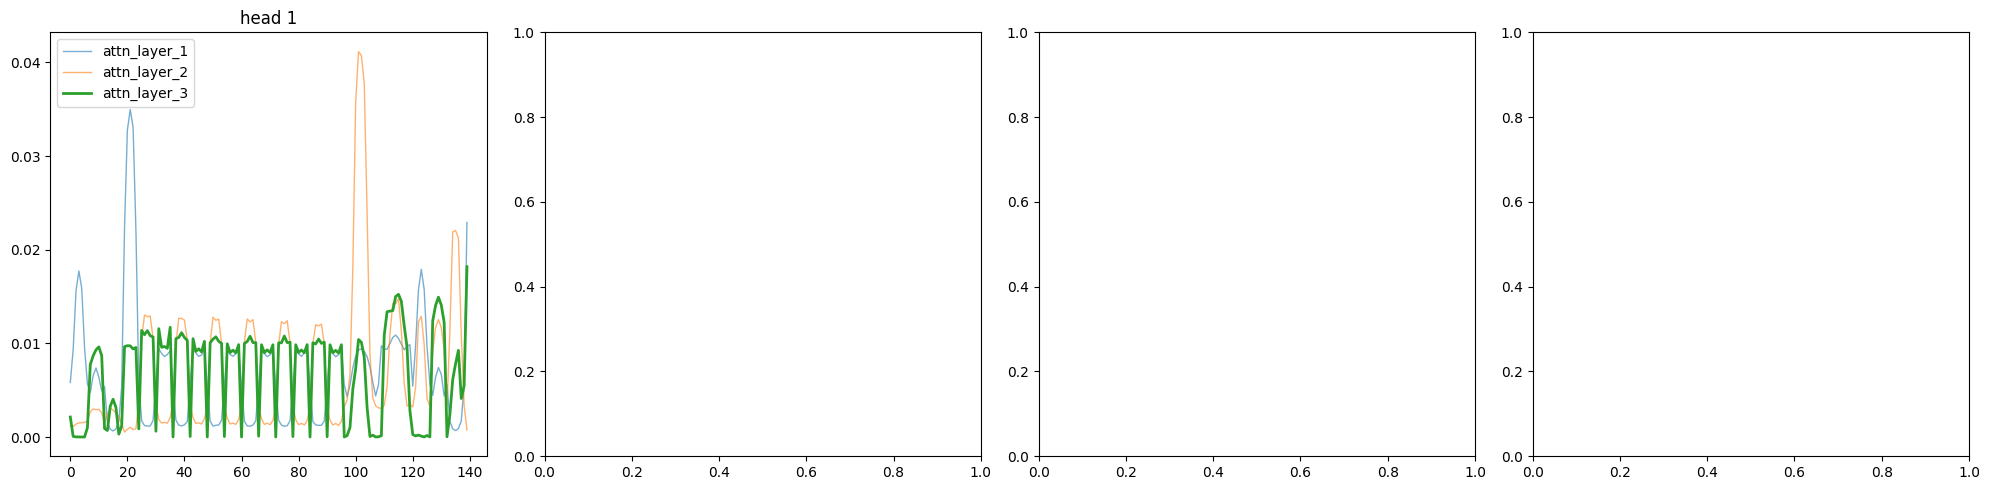

In [53]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

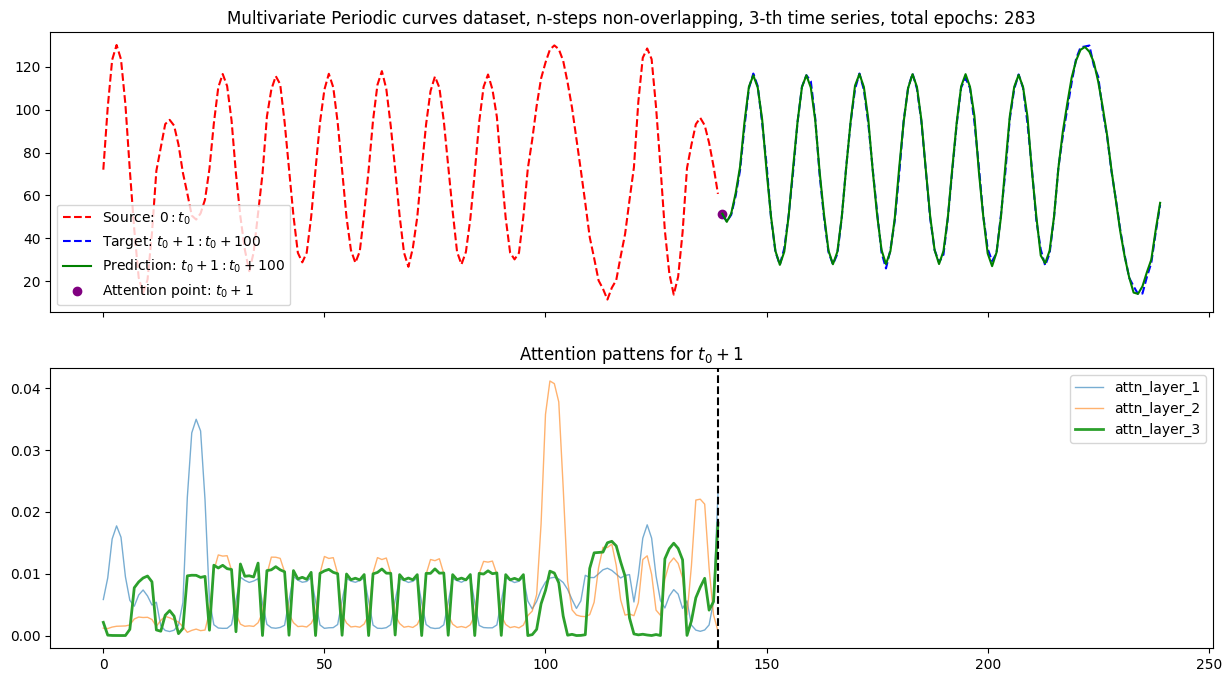

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX[:, ith], '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX[:, ith], '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step, ith].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Multivariate Periodic curves dataset, n-steps non-overlapping, {ith}-th time series, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 5: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target

### Step function

In [55]:
DATASET_NAME = "step"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.StepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

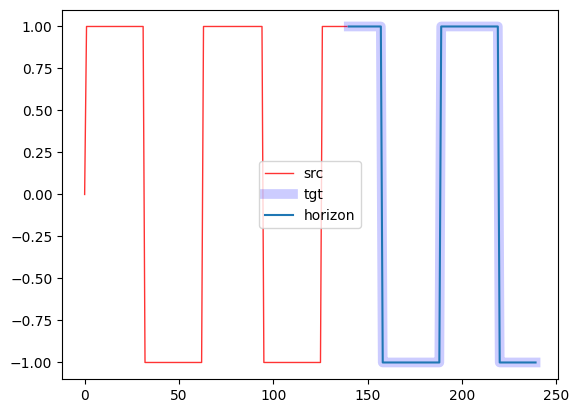

In [56]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [57]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden*2,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [58]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1.0566	val_loss=1.0008	train_mape_loss=1.0026	val_mape_loss=0.9999	R_p=['0.9999', '1.0228']
epoch=1	train_loss=1.0050	val_loss=1.0001	train_mape_loss=1.0000	val_mape_loss=0.9999	R_p=['0.9999', '1.0102']
epoch=2	train_loss=1.0038	val_loss=0.9999	train_mape_loss=1.0001	val_mape_loss=1.0000	R_p=['1.0000', '0.9961']
epoch=3	train_loss=1.0037	val_loss=1.0004	train_mape_loss=1.0001	val_mape_loss=1.0000	R_p=['1.0000', '0.9825']
epoch=4	train_loss=1.0024	val_loss=1.0000	train_mape_loss=1.0000	val_mape_loss=1.0000	R_p=['1.0000', '0.9993']
epoch=5	train_loss=1.0034	val_loss=1.0011	train_mape_loss=1.0002	val_mape_loss=0.9999	R_p=['0.9999', '1.0272']
epoch=6	train_loss=1.0022	val_loss=1.0003	train_mape_loss=0.9999	val_mape_loss=1.0000	R_p=['1.0000', '0.9861']
epoch=7	train_loss=1.0015	val_loss=1.0002	train_mape_loss=0.9998	val_mape_loss=1.0000	R_p=['1.0000', '0.9883']
epoch=8	train_loss=1.0020	val_loss=1.0027	train_mape_loss=0.9999	val_mape_loss=1.0001	R_p=['1.0001', '0.9582']
e

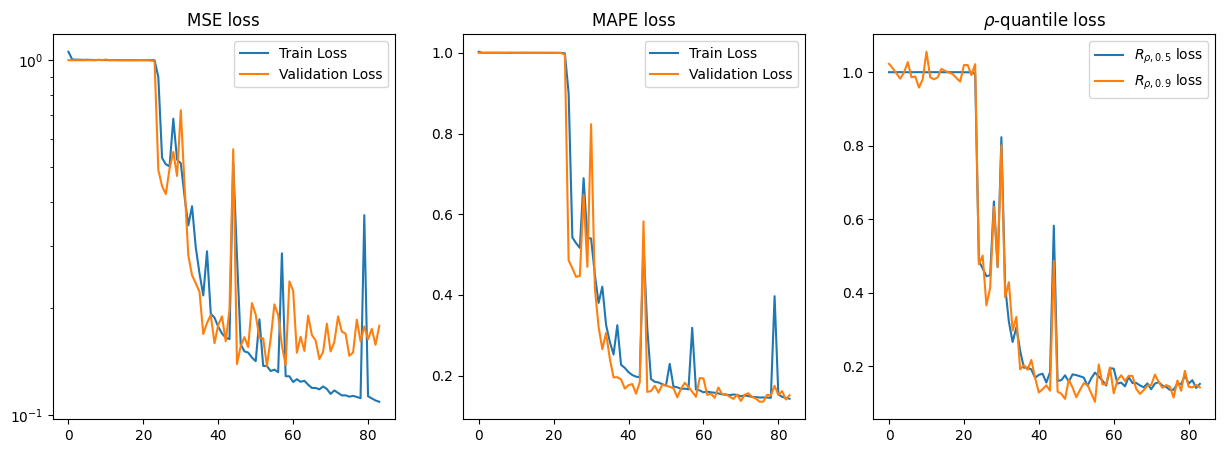

In [59]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [60]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.17439251852035523,
 0.15015198528766632,
 [0.15015199780464172, 0.14149868488311768])

In [61]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [62]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.13522907280921936,
 0.1454964872598648,
 tensor([0.1455, 0.1505], device='cuda:0'))

#### Predict

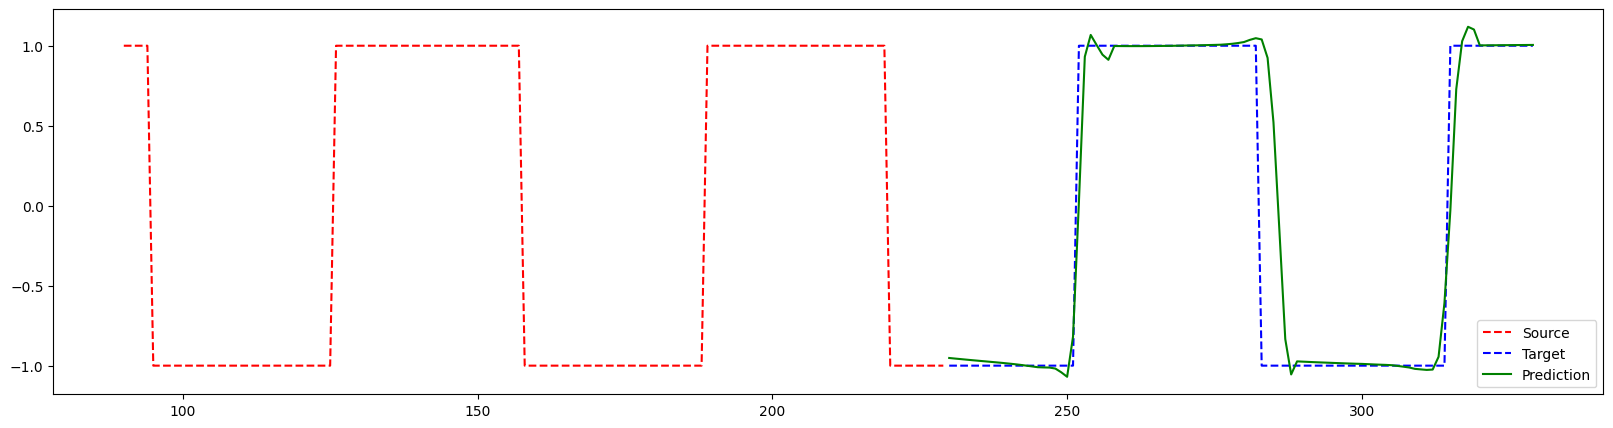

In [63]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [64]:
inspect_step = 0

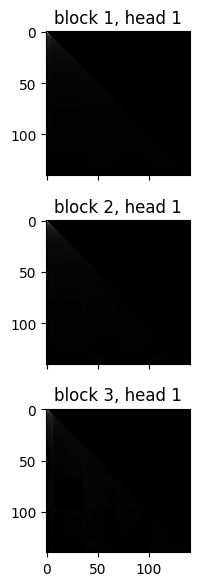

In [65]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

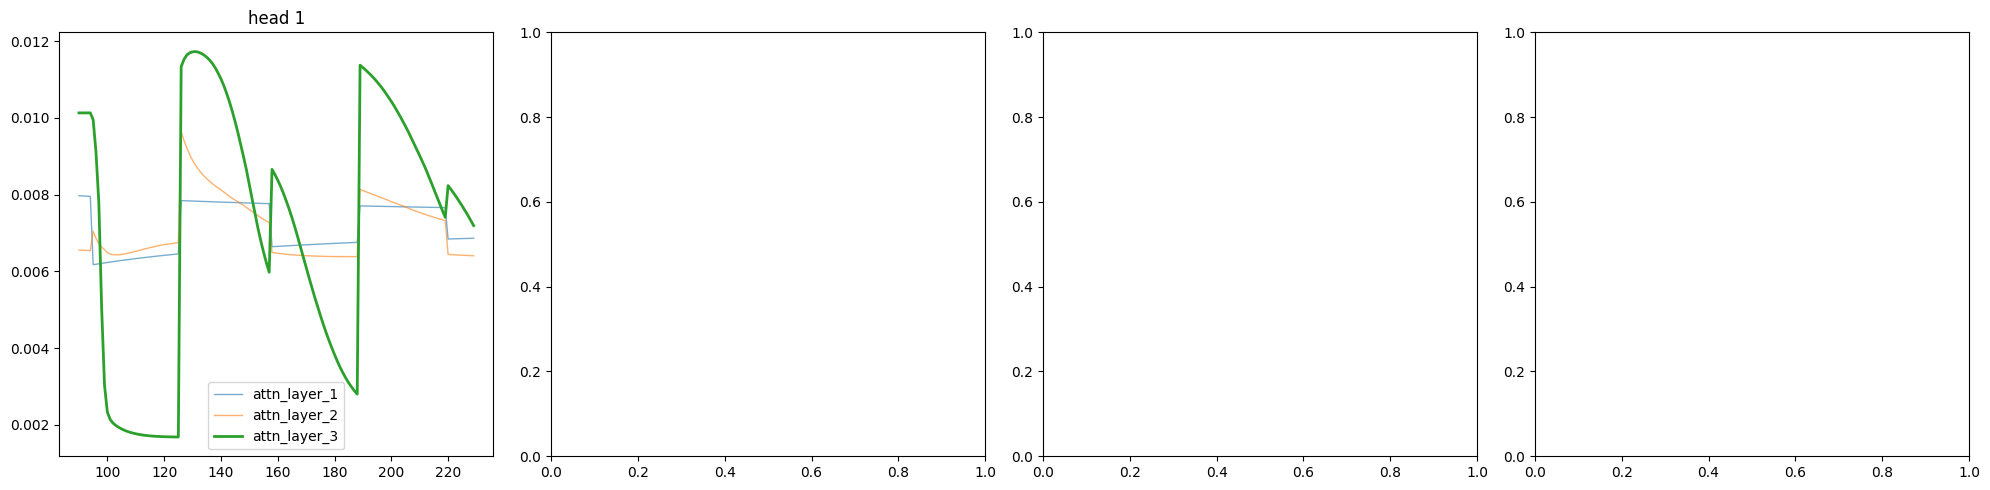

In [66]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

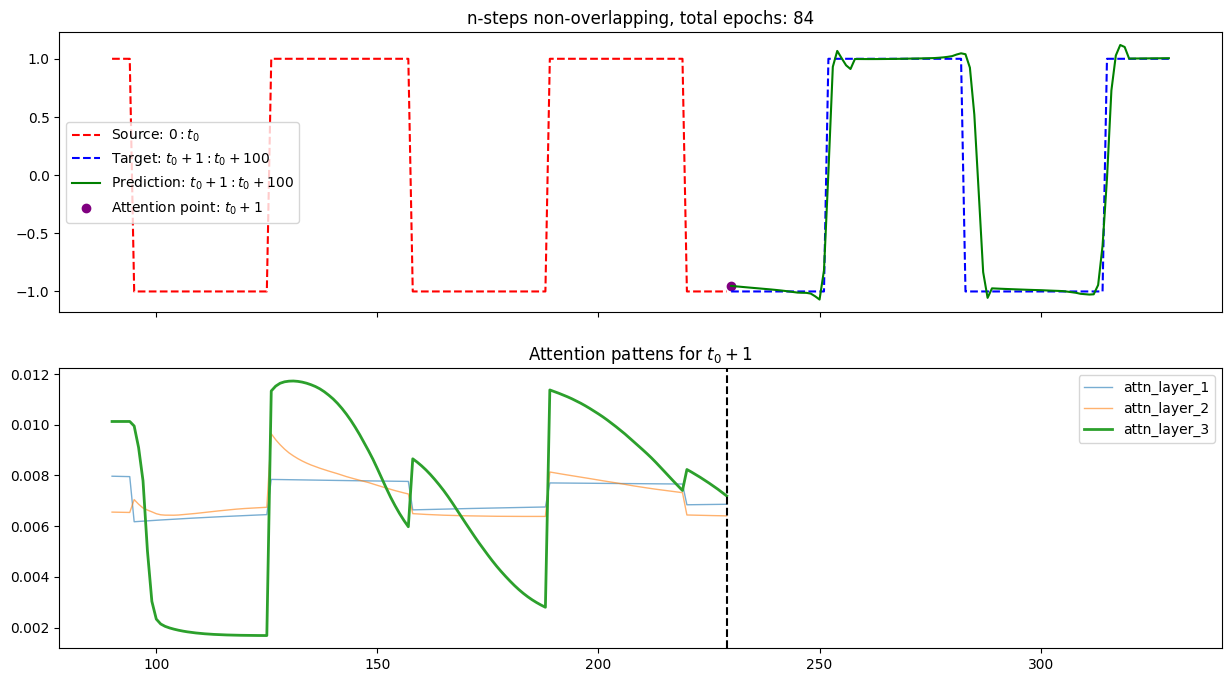

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Step function

In [68]:
DATASET_NAME = "step_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

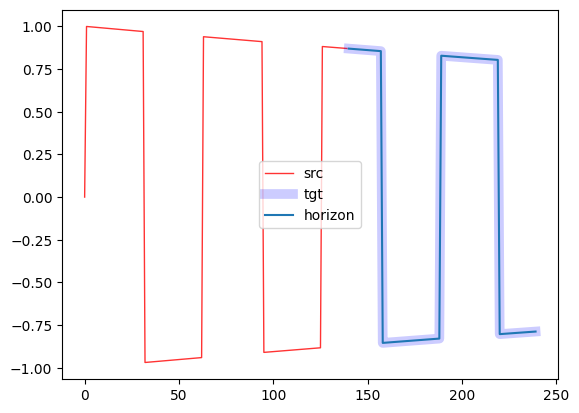

In [69]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [70]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [71]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.0828	val_loss=0.0606	train_mape_loss=8.3964	val_mape_loss=2.0397	R_p=['1.0327', '1.1469']
epoch=1	train_loss=0.0587	val_loss=0.0604	train_mape_loss=3.1901	val_mape_loss=1.6738	R_p=['1.0195', '1.1030']
epoch=2	train_loss=0.0578	val_loss=0.0601	train_mape_loss=2.6132	val_mape_loss=1.0010	R_p=['1.0000', '1.0066']
epoch=3	train_loss=0.0575	val_loss=0.0603	train_mape_loss=2.3118	val_mape_loss=1.5000	R_p=['1.0138', '1.0822']
epoch=4	train_loss=0.0573	val_loss=0.0605	train_mape_loss=2.0807	val_mape_loss=1.9286	R_p=['1.0278', '0.9195']
epoch=5	train_loss=0.0574	val_loss=0.0608	train_mape_loss=2.2386	val_mape_loss=2.3144	R_p=['1.0426', '0.9027']
epoch=6	train_loss=0.0571	val_loss=0.0605	train_mape_loss=1.8451	val_mape_loss=1.9373	R_p=['1.0290', '1.1348']
epoch=7	train_loss=0.0573	val_loss=0.0602	train_mape_loss=2.0623	val_mape_loss=1.0094	R_p=['1.0003', '1.0157']
epoch=8	train_loss=0.0571	val_loss=0.0603	train_mape_loss=1.8135	val_mape_loss=1.3717	R_p=['1.0091', '0.9492']
e

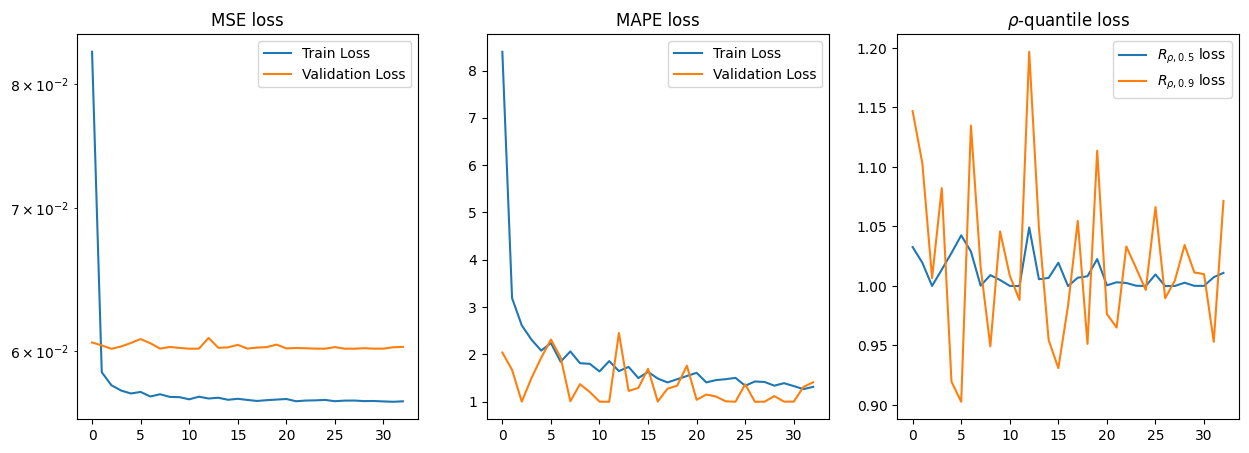

In [72]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [73]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.057940038621425625,
 1.4758274269104004,
 [1.011977195739746, 1.0800000429153442])

In [74]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [75]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.057799251317977904,
 0.9994613819122314,
 tensor([1.0000, 1.0116], device='cuda:0'))

#### Predict

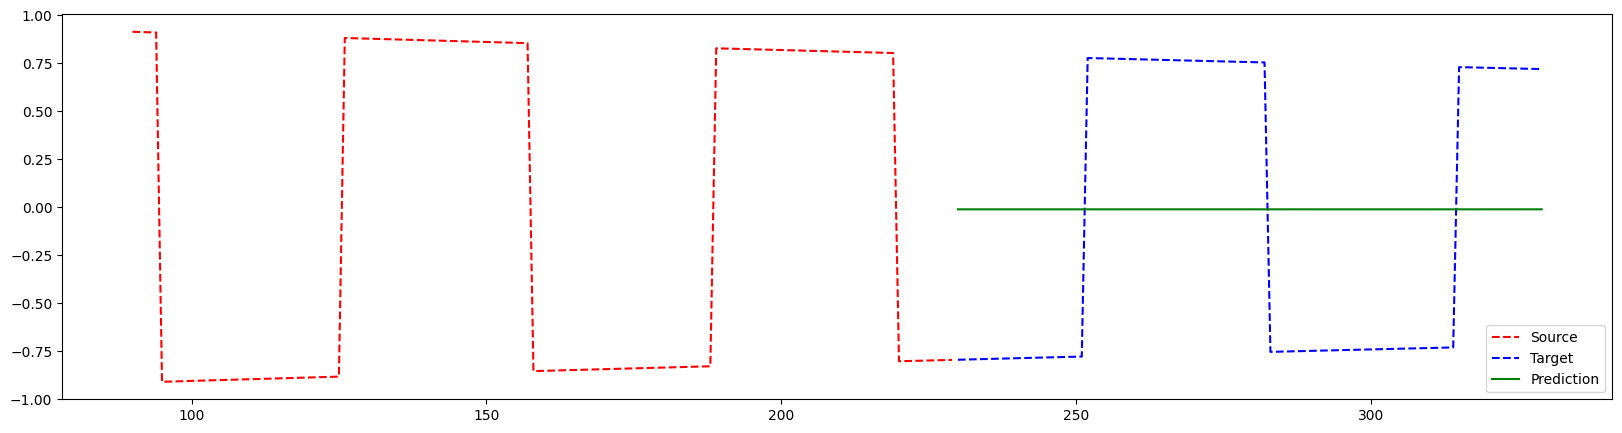

In [76]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [77]:
inspect_step = 0

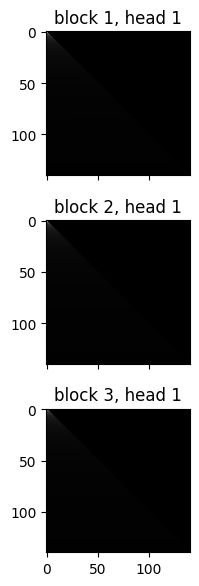

In [78]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

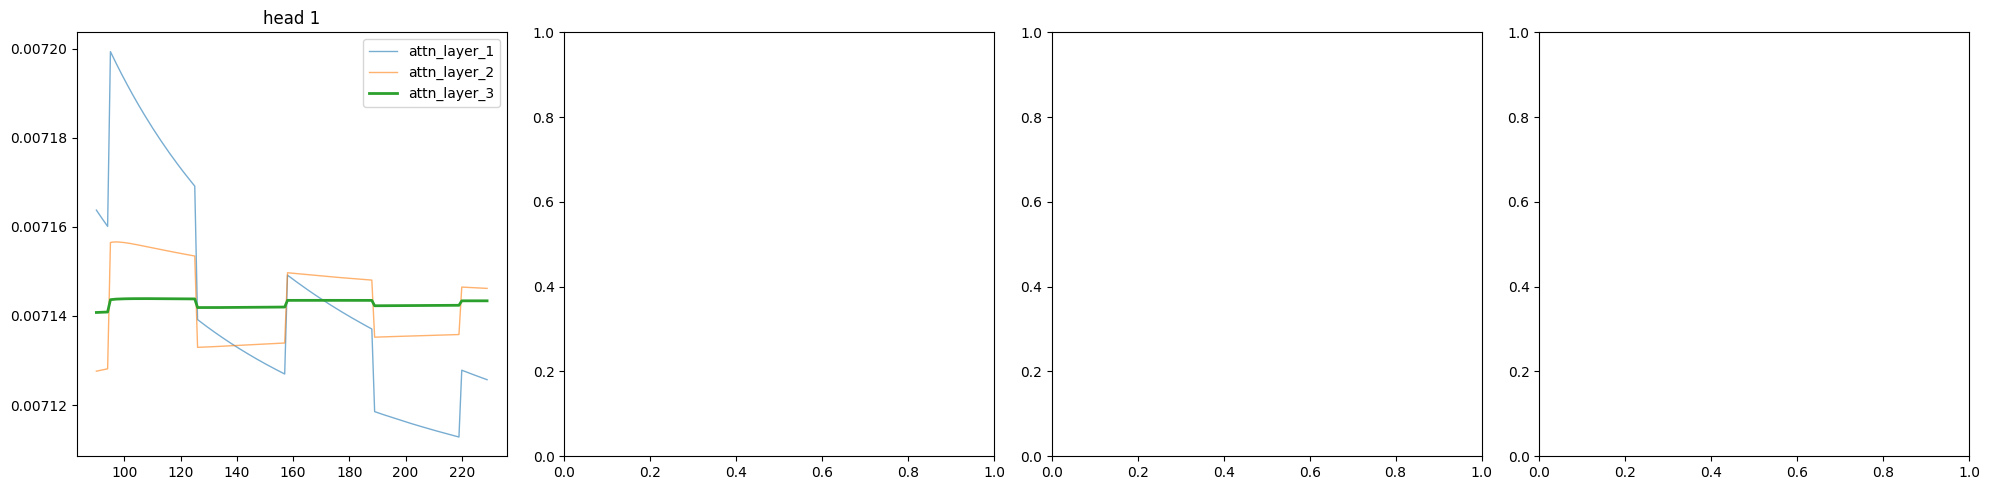

In [79]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

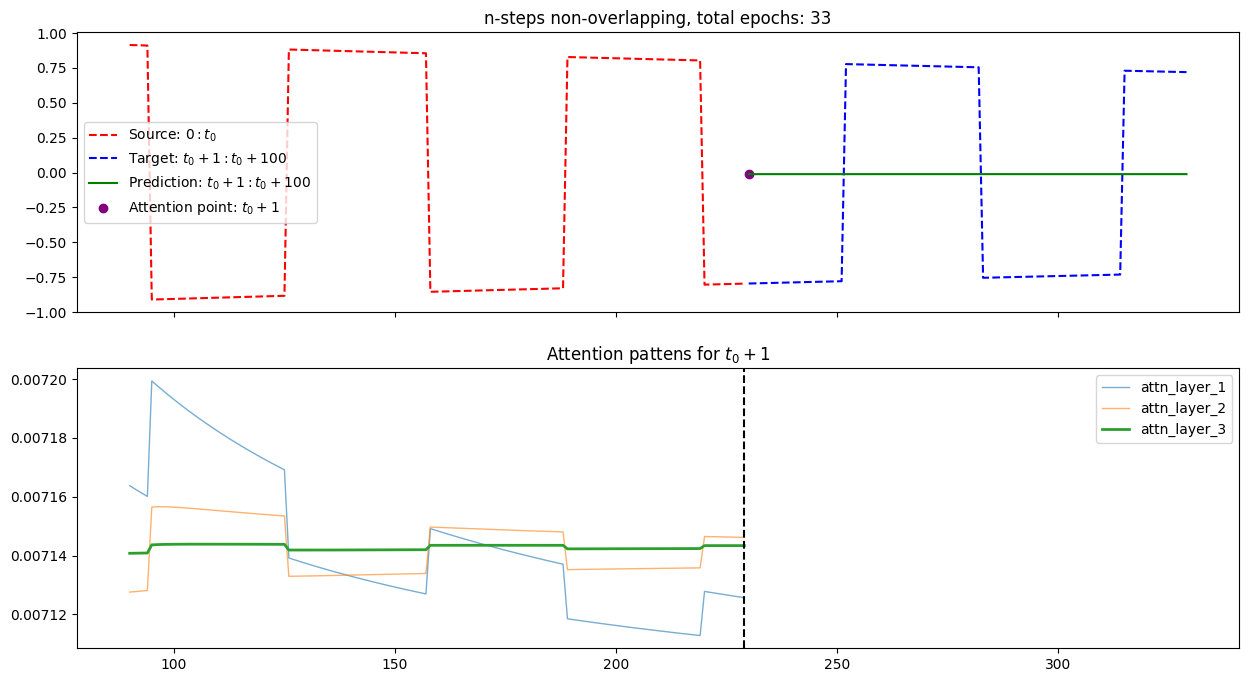

In [80]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Step function

In [81]:
DATASET_NAME = "step_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

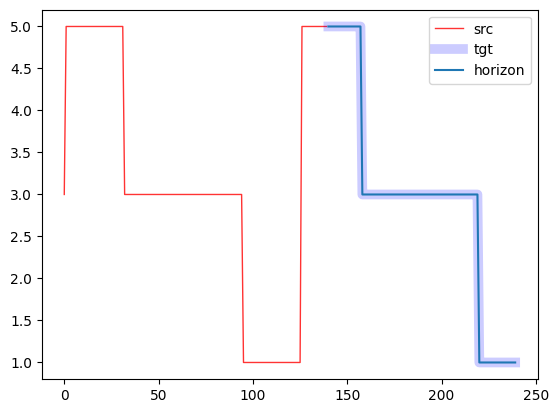

In [82]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [83]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [84]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2.2189	val_loss=2.0128	train_mape_loss=0.6499	val_mape_loss=0.6492	R_p=['0.3563', '0.3183']
epoch=1	train_loss=2.0361	val_loss=1.9925	train_mape_loss=0.6239	val_mape_loss=0.5929	R_p=['0.3308', '0.3340']
epoch=2	train_loss=2.0302	val_loss=1.9924	train_mape_loss=0.6212	val_mape_loss=0.5995	R_p=['0.3338', '0.3322']
epoch=3	train_loss=2.0293	val_loss=1.9951	train_mape_loss=0.6214	val_mape_loss=0.5916	R_p=['0.3373', '0.3510']
epoch=4	train_loss=2.0276	val_loss=2.0042	train_mape_loss=0.6195	val_mape_loss=0.6367	R_p=['0.3506', '0.3218']
epoch=5	train_loss=2.0284	val_loss=1.9958	train_mape_loss=0.6212	val_mape_loss=0.6184	R_p=['0.3424', '0.3269']
epoch=6	train_loss=2.0269	val_loss=1.9924	train_mape_loss=0.6195	val_mape_loss=0.5986	R_p=['0.3334', '0.3325']
epoch=7	train_loss=2.0250	val_loss=1.9926	train_mape_loss=0.6194	val_mape_loss=0.6020	R_p=['0.3349', '0.3315']
epoch=8	train_loss=2.0258	val_loss=1.9926	train_mape_loss=0.6190	val_mape_loss=0.5926	R_p=['0.3308', '0.3344']
e

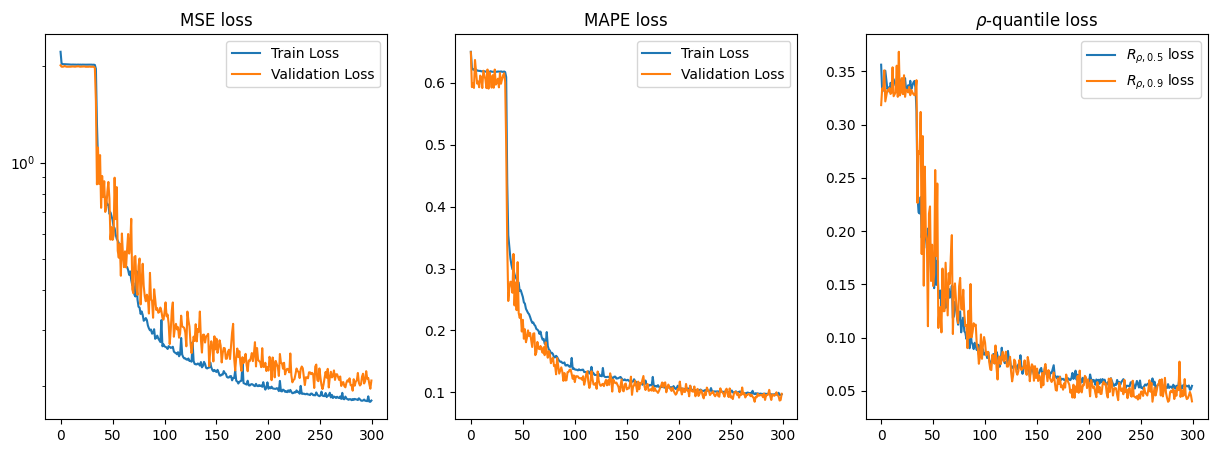

In [85]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [86]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.20921470665931702,
 0.09939335405826569,
 [0.05534364655613899, 0.039833713322877884])

In [87]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [88]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.19147036755084992,
 0.09343275701999665,
 tensor([0.0560, 0.0512], device='cuda:0'))

#### Predict

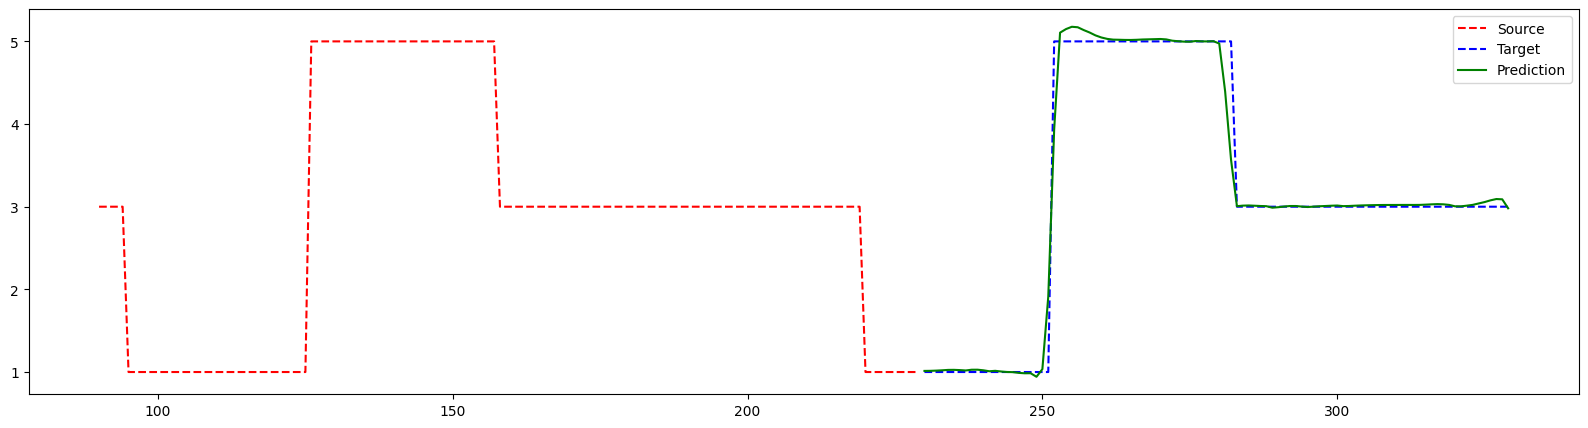

In [89]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [90]:
inspect_step = 0

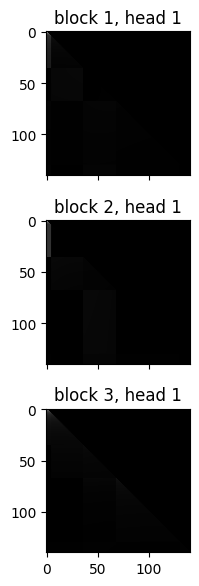

In [91]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

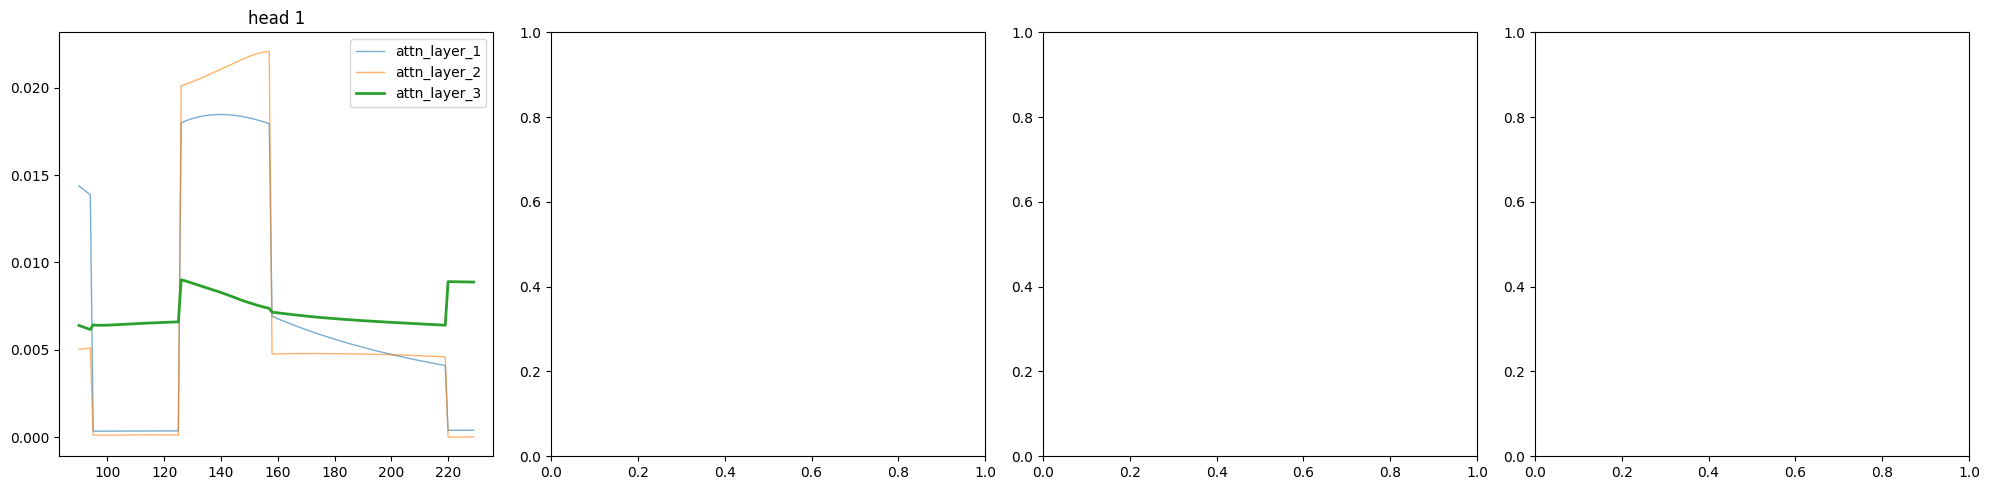

In [92]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

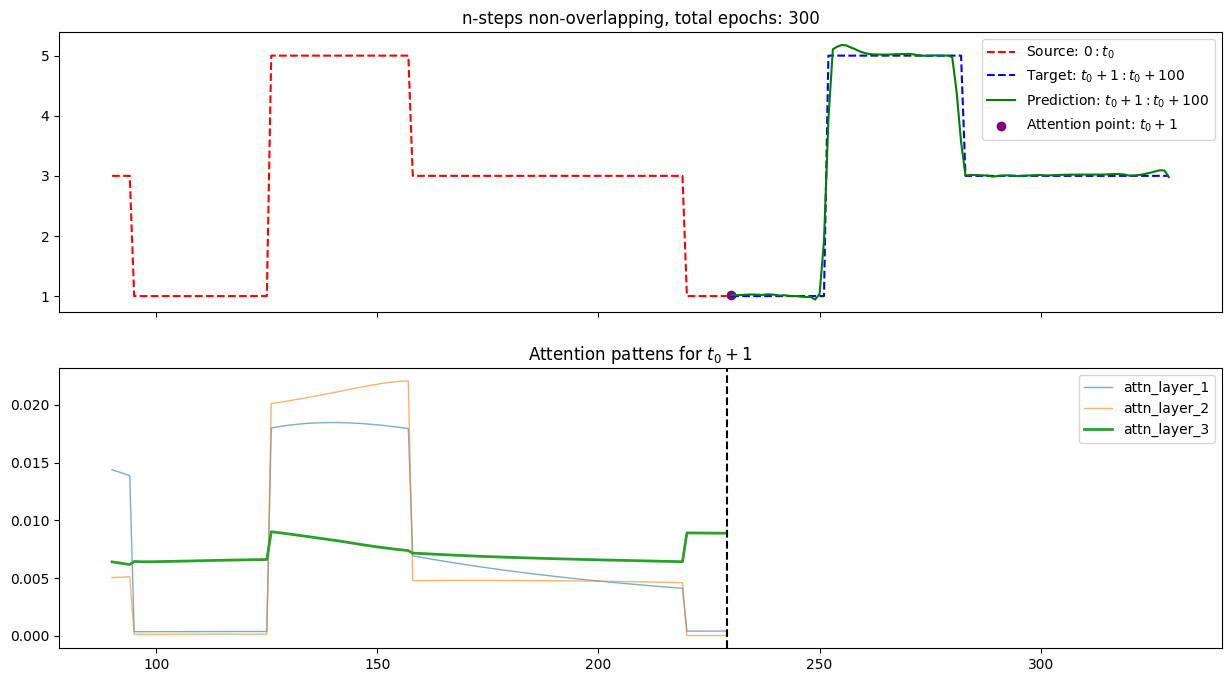

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 6: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target

### Sine function

In [94]:
DATASET_NAME = "sine"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

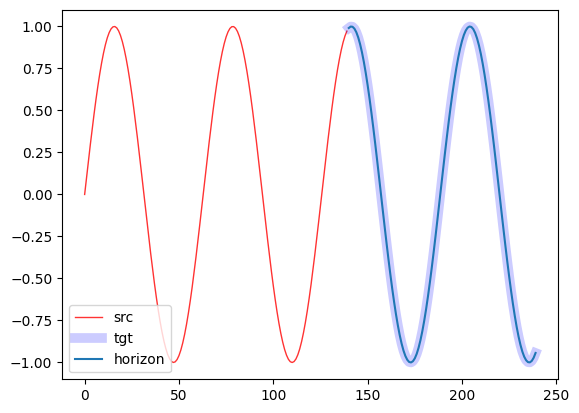

In [95]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [96]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [97]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.5349	val_loss=0.5031	train_mape_loss=2.1045	val_mape_loss=1.2574	R_p=['1.0011', '0.9439']
epoch=1	train_loss=0.5040	val_loss=0.5011	train_mape_loss=1.4106	val_mape_loss=1.0227	R_p=['0.9999', '1.0006']
epoch=2	train_loss=0.5027	val_loss=0.5015	train_mape_loss=1.3221	val_mape_loss=1.0998	R_p=['1.0003', '0.9729']
epoch=3	train_loss=0.5023	val_loss=0.5013	train_mape_loss=1.3269	val_mape_loss=1.1061	R_p=['1.0000', '1.0181']
epoch=4	train_loss=0.5017	val_loss=0.5012	train_mape_loss=1.2706	val_mape_loss=1.0776	R_p=['1.0000', '1.0124']
epoch=5	train_loss=0.5010	val_loss=0.5014	train_mape_loss=1.2319	val_mape_loss=1.0767	R_p=['1.0002', '0.9775']
epoch=6	train_loss=0.5014	val_loss=0.5026	train_mape_loss=1.2301	val_mape_loss=1.2676	R_p=['1.0005', '1.0493']
epoch=7	train_loss=0.5010	val_loss=0.5011	train_mape_loss=1.2039	val_mape_loss=1.0458	R_p=['0.9999', '1.0057']
epoch=8	train_loss=0.5010	val_loss=0.5012	train_mape_loss=1.2011	val_mape_loss=1.0302	R_p=['1.0001', '0.9872']
e

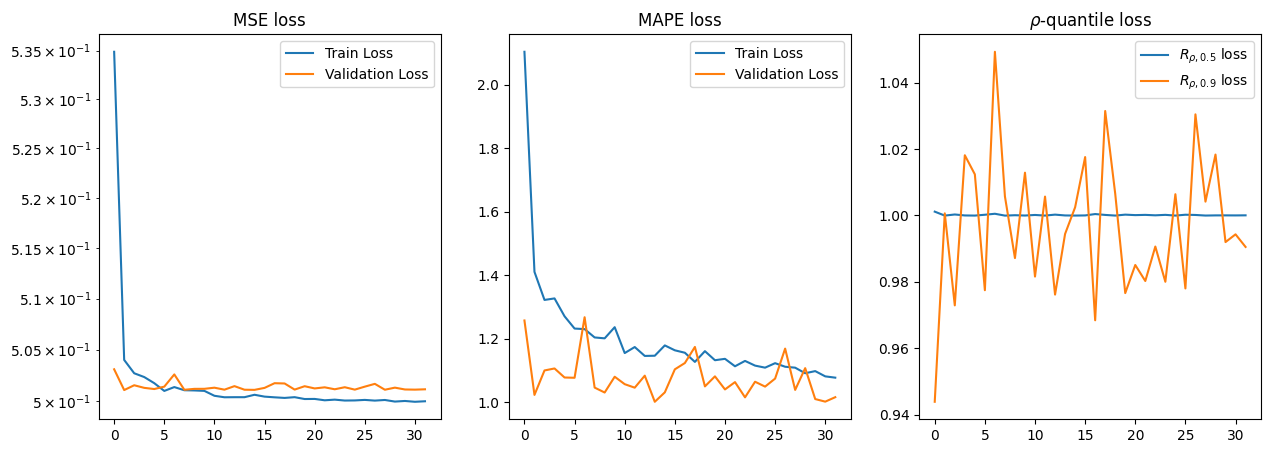

In [98]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [99]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.5005796790122986,
 1.0215036668777466,
 [1.0000296831130981, 0.9903291463851929])

In [100]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [101]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.5005061712265014,
 1.0302653741836547,
 tensor([1.0000, 1.0005], device='cuda:0'))

#### Predict

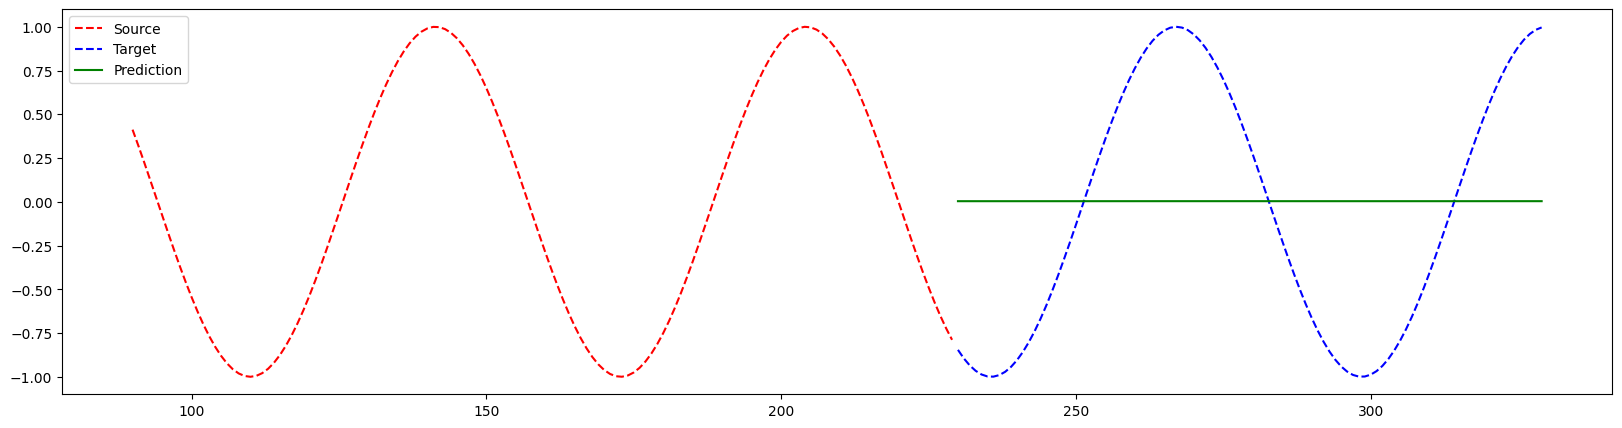

In [102]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [103]:
inspect_step = 0

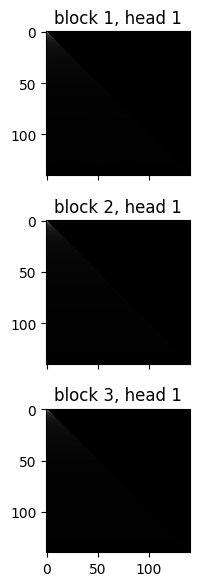

In [104]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

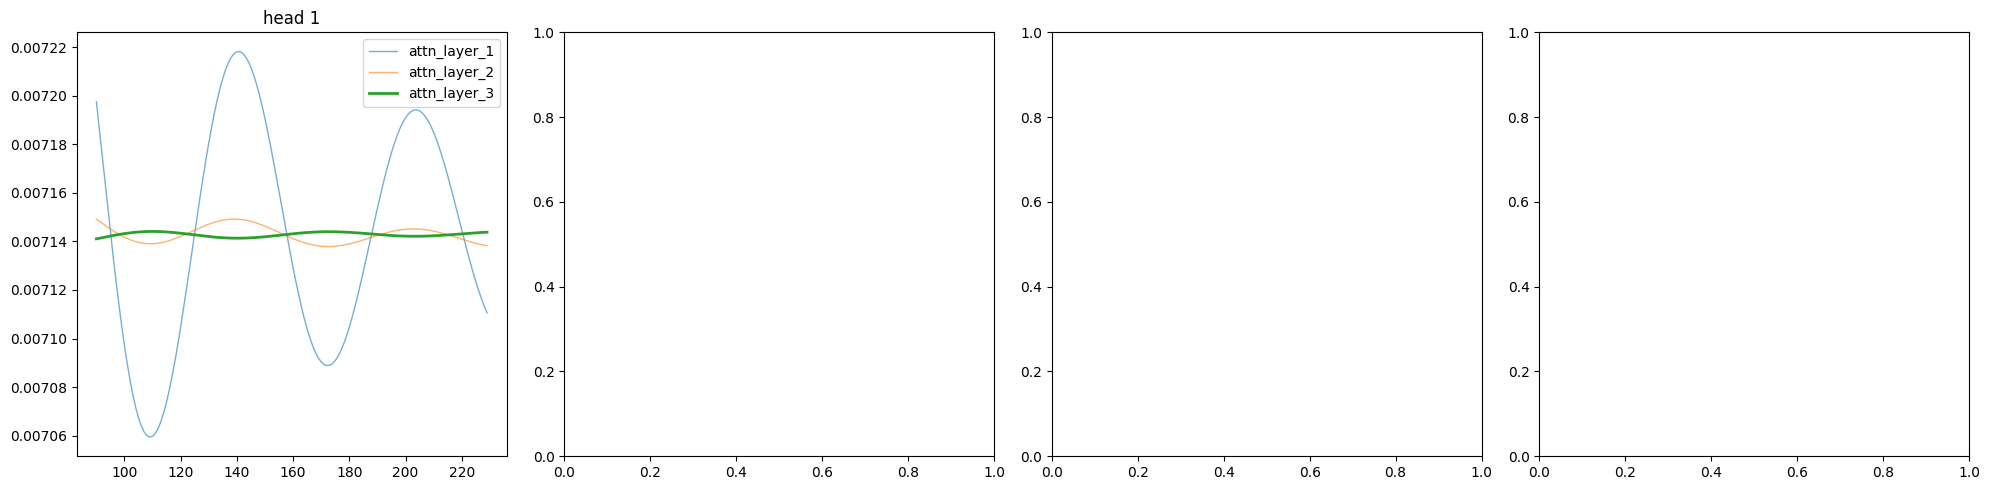

In [105]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

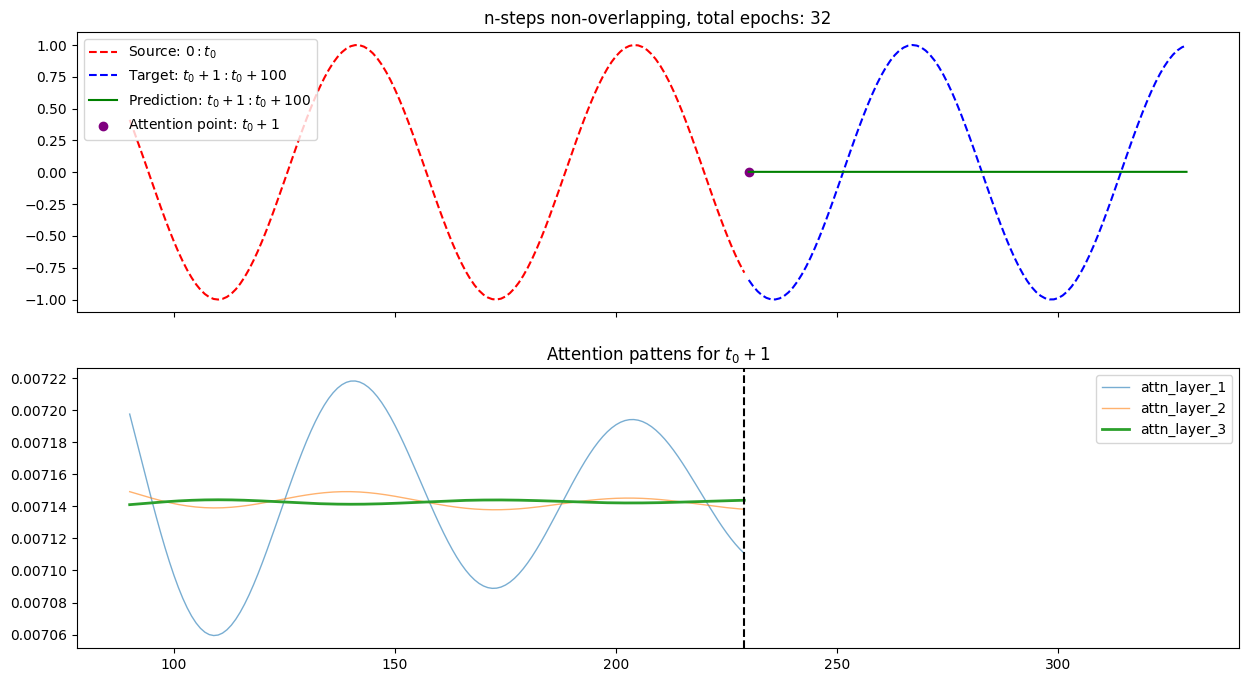

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sine function

In [107]:
DATASET_NAME = "sine_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

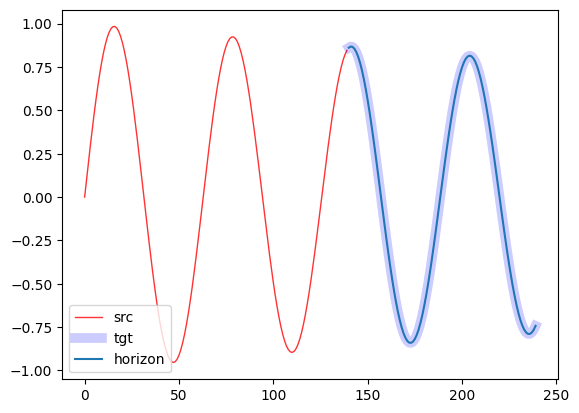

In [108]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [109]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [110]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.0648	val_loss=0.0347	train_mape_loss=67.5170	val_mape_loss=10.1563	R_p=['1.0464', '0.9090']
epoch=1	train_loss=0.0304	val_loss=0.0348	train_mape_loss=20.8376	val_mape_loss=11.5127	R_p=['1.0563', '1.2121']
epoch=2	train_loss=0.0297	val_loss=0.0344	train_mape_loss=16.9378	val_mape_loss=4.4103	R_p=['1.0102', '0.9560']
epoch=3	train_loss=0.0293	val_loss=0.0344	train_mape_loss=14.9002	val_mape_loss=2.6877	R_p=['1.0030', '0.9744']
epoch=4	train_loss=0.0290	val_loss=0.0345	train_mape_loss=11.6898	val_mape_loss=5.6863	R_p=['1.0170', '0.9442']
epoch=5	train_loss=0.0289	val_loss=0.0344	train_mape_loss=10.8510	val_mape_loss=3.3743	R_p=['1.0053', '1.0436']
epoch=6	train_loss=0.0288	val_loss=0.0344	train_mape_loss=10.3019	val_mape_loss=2.5893	R_p=['1.0025', '1.0290']
epoch=7	train_loss=0.0288	val_loss=0.0344	train_mape_loss=9.2333	val_mape_loss=4.4926	R_p=['1.0104', '1.0652']
epoch=8	train_loss=0.0288	val_loss=0.0350	train_mape_loss=9.4510	val_mape_loss=14.4191	R_p=['1.0801', '

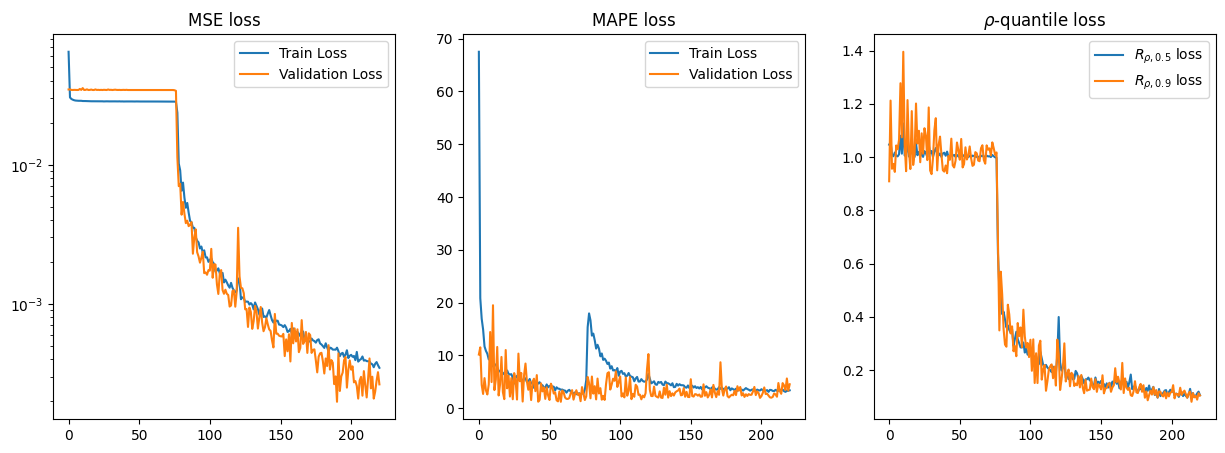

In [111]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [112]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.000385402787826024,
 2.980226261138916,
 [0.13133351504802704, 0.1186438724398613])

In [113]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [114]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.0003218335702549666,
 2.2925717411041258,
 tensor([0.1244, 0.1152], device='cuda:0'))

#### Predict

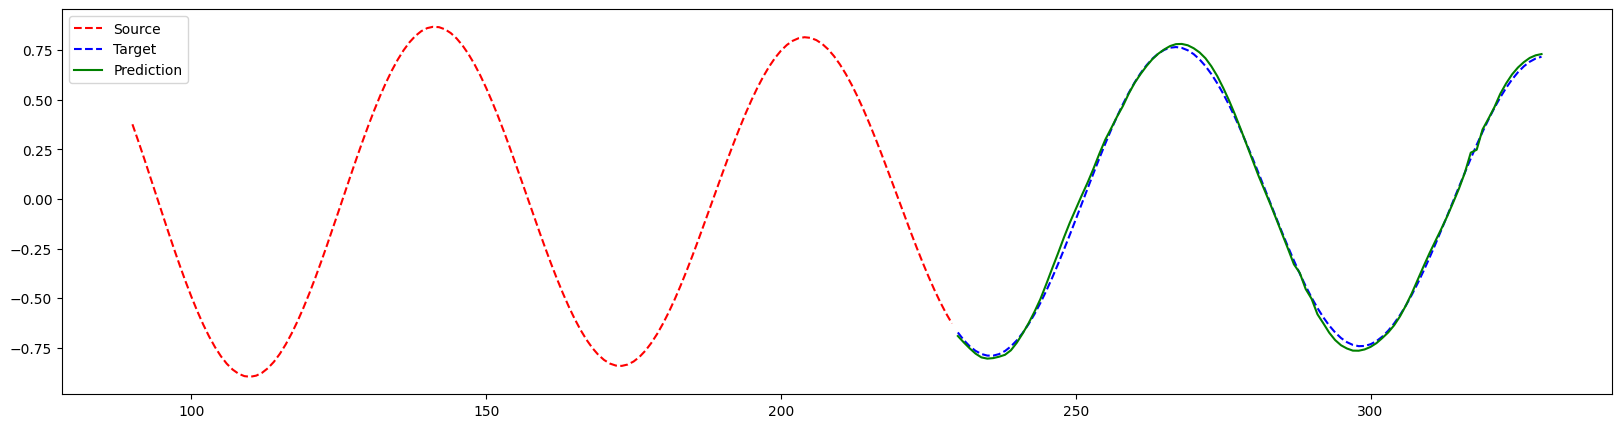

In [115]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [116]:
inspect_step = 0

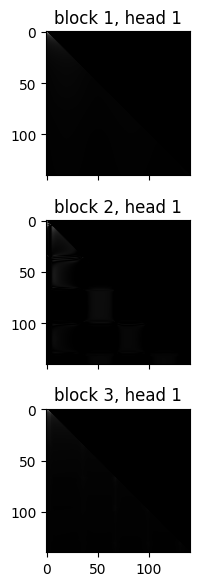

In [117]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

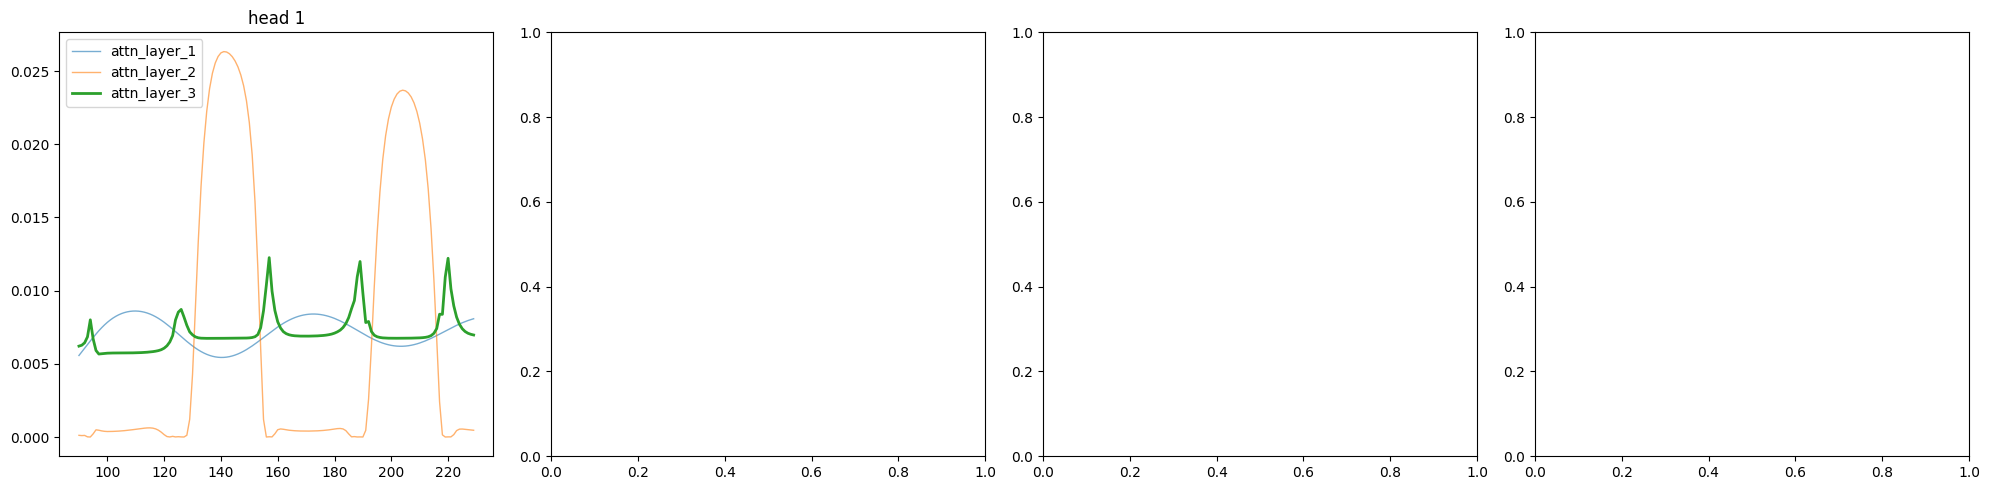

In [118]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

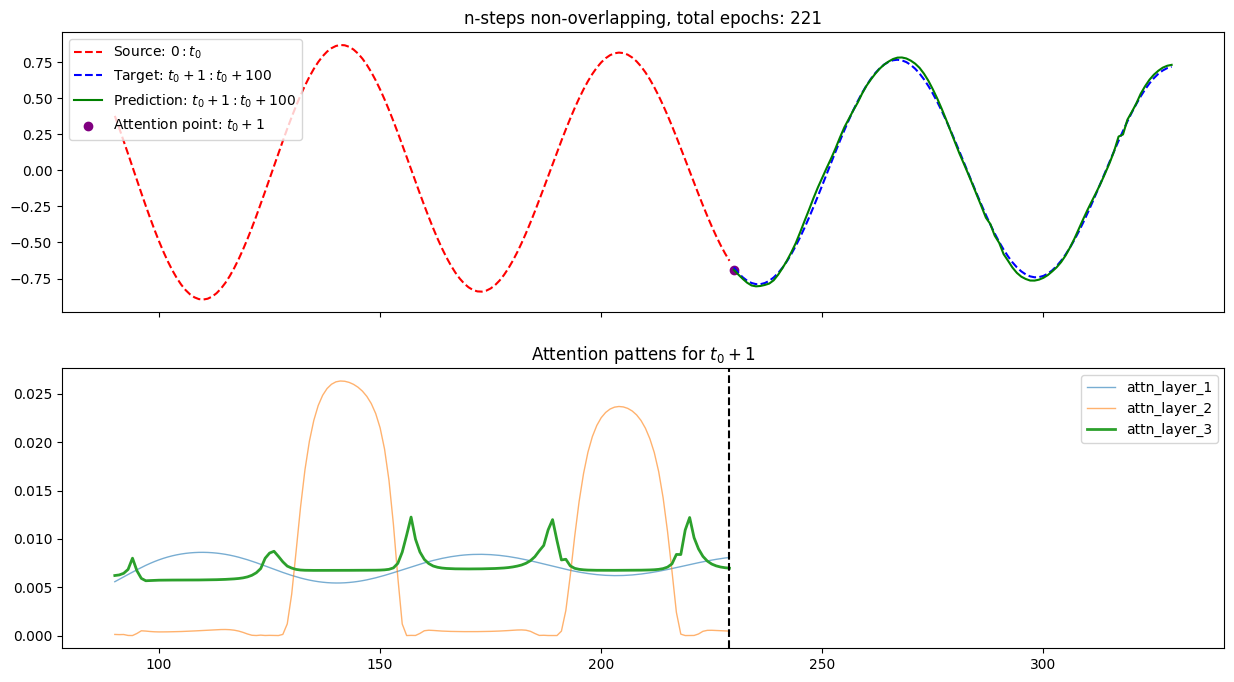

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sine function

In [120]:
DATASET_NAME = "sine_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

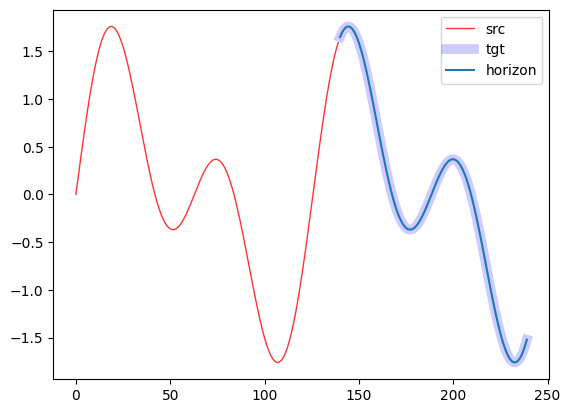

In [121]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [122]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [123]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1.0348	val_loss=0.9969	train_mape_loss=1.6298	val_mape_loss=1.1043	R_p=['1.0010', '0.9586']
epoch=1	train_loss=1.0099	val_loss=1.0025	train_mape_loss=1.2601	val_mape_loss=1.3792	R_p=['1.0035', '1.0902']
epoch=2	train_loss=1.0072	val_loss=0.9952	train_mape_loss=1.1810	val_mape_loss=1.0029	R_p=['1.0000', '0.9936']
epoch=3	train_loss=1.0066	val_loss=0.9952	train_mape_loss=1.1665	val_mape_loss=1.0003	R_p=['1.0000', '0.9906']
epoch=4	train_loss=1.0070	val_loss=0.9957	train_mape_loss=1.1401	val_mape_loss=1.0986	R_p=['1.0001', '1.0233']
epoch=5	train_loss=1.0059	val_loss=0.9990	train_mape_loss=1.1329	val_mape_loss=1.1898	R_p=['1.0022', '0.9395']
epoch=6	train_loss=1.0057	val_loss=0.9958	train_mape_loss=1.1210	val_mape_loss=1.1059	R_p=['1.0001', '1.0253']
epoch=7	train_loss=1.0056	val_loss=0.9951	train_mape_loss=1.1114	val_mape_loss=1.0225	R_p=['0.9999', '1.0011']
epoch=8	train_loss=1.0063	val_loss=0.9957	train_mape_loss=1.1414	val_mape_loss=1.0367	R_p=['1.0003', '0.9761']
e

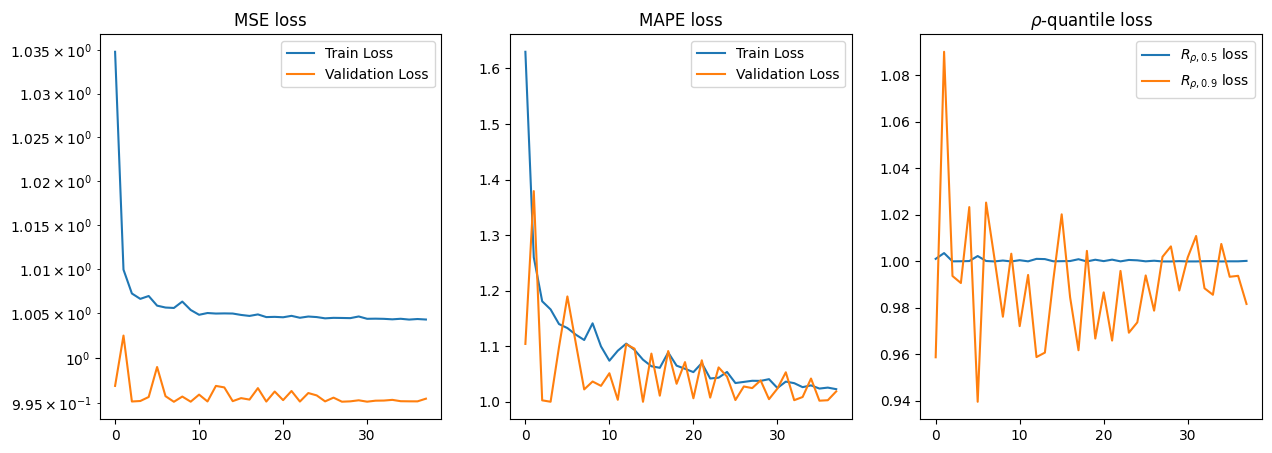

In [124]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [125]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.989105363368988,
 1.021121516227722,
 [0.9999966621398926, 0.9930587410926819])

In [126]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [127]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.9892132730484009,
 1.0254375276565553,
 tensor([1.0001, 1.0130], device='cuda:0'))

#### Predict

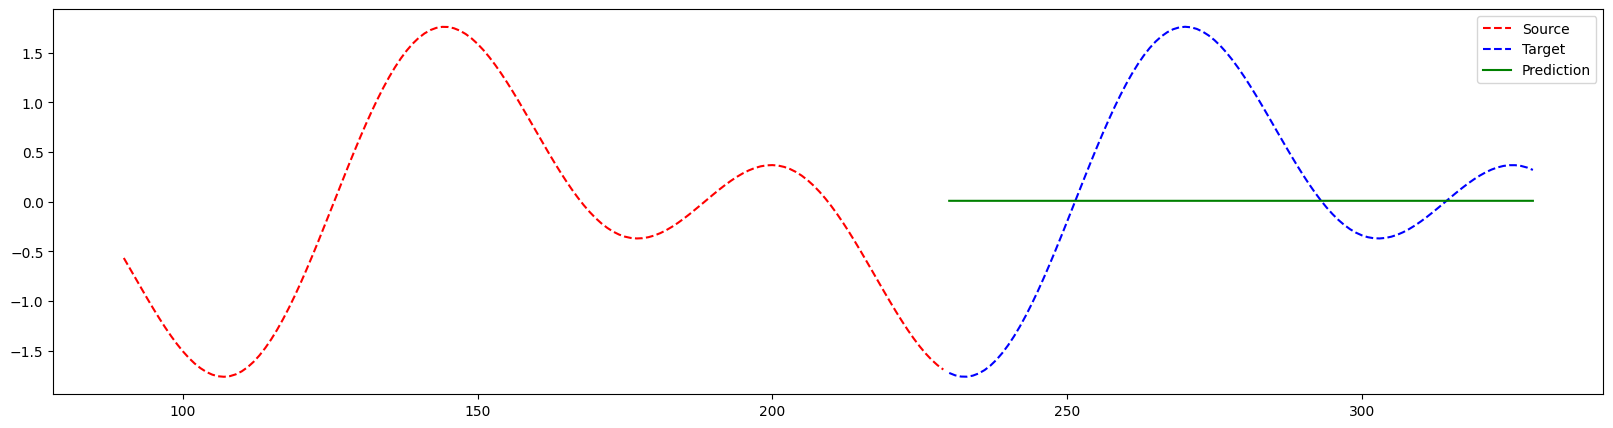

In [128]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [129]:
inspect_step = 0

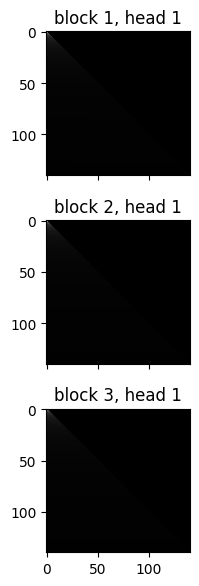

In [130]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

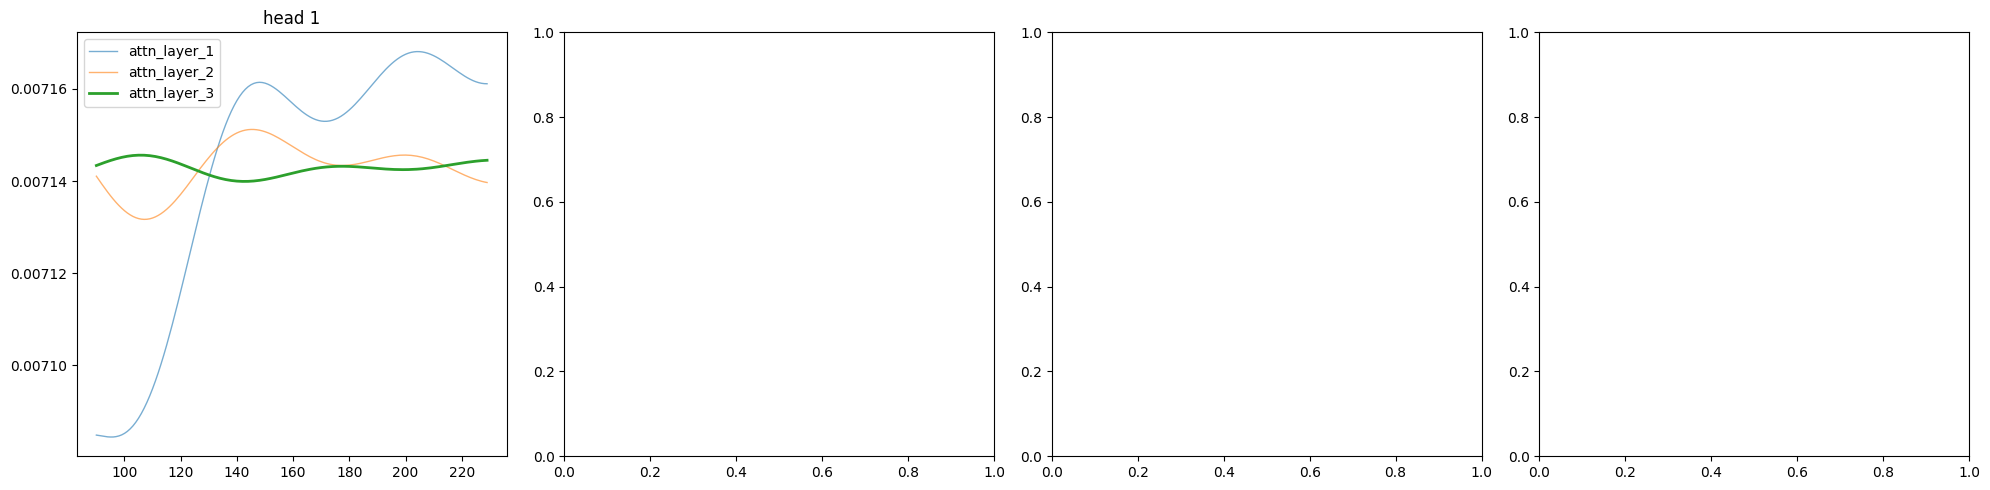

In [131]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

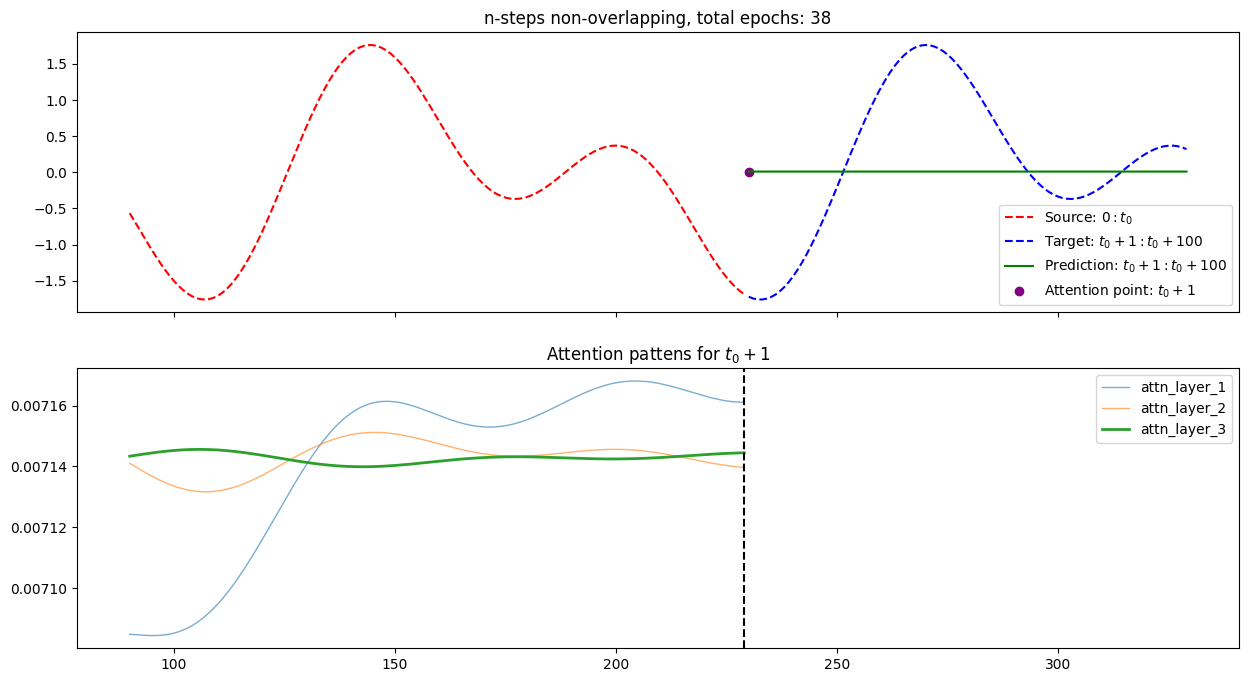

In [132]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 7: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

### Sawtooth function

In [133]:
DATASET_NAME = "sawtooth"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

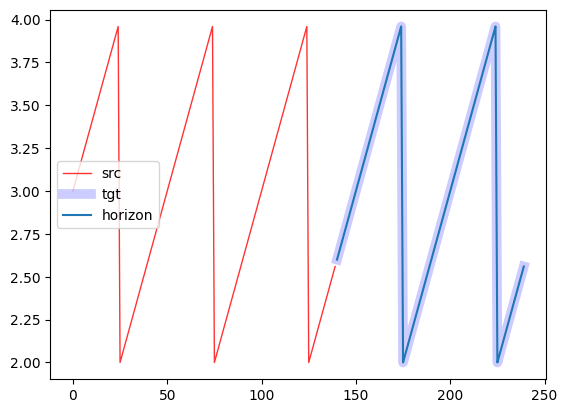

In [134]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [135]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [136]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.5614	val_loss=0.3524	train_mape_loss=0.2087	val_mape_loss=0.1894	R_p=['0.1710', '0.1338']
epoch=1	train_loss=0.3595	val_loss=0.3352	train_mape_loss=0.1820	val_mape_loss=0.1810	R_p=['0.1681', '0.1561']
epoch=2	train_loss=0.3541	val_loss=0.3342	train_mape_loss=0.1811	val_mape_loss=0.1800	R_p=['0.1679', '0.1595']
epoch=3	train_loss=0.3526	val_loss=0.3336	train_mape_loss=0.1810	val_mape_loss=0.1792	R_p=['0.1678', '0.1623']
epoch=4	train_loss=0.3507	val_loss=0.3332	train_mape_loss=0.1806	val_mape_loss=0.1783	R_p=['0.1678', '0.1665']
epoch=5	train_loss=0.3503	val_loss=0.3332	train_mape_loss=0.1805	val_mape_loss=0.1777	R_p=['0.1678', '0.1692']
epoch=6	train_loss=0.3500	val_loss=0.3335	train_mape_loss=0.1805	val_mape_loss=0.1769	R_p=['0.1678', '0.1725']
epoch=7	train_loss=0.3497	val_loss=0.3332	train_mape_loss=0.1805	val_mape_loss=0.1783	R_p=['0.1678', '0.1663']
epoch=8	train_loss=0.3497	val_loss=0.3332	train_mape_loss=0.1805	val_mape_loss=0.1781	R_p=['0.1678', '0.1672']
e

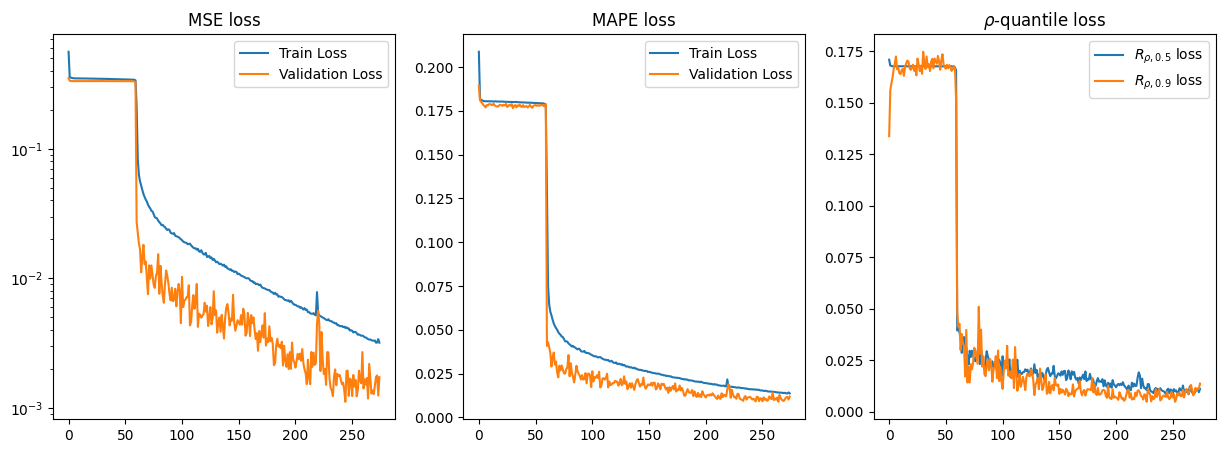

In [137]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [138]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.0018016220703721047,
 0.01218488173186779,
 [0.011292271316051483, 0.012851766310632229])

In [139]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [140]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.0011017062375321984,
 0.009038676455616951,
 tensor([0.0084, 0.0061], device='cuda:0'))

#### Predict

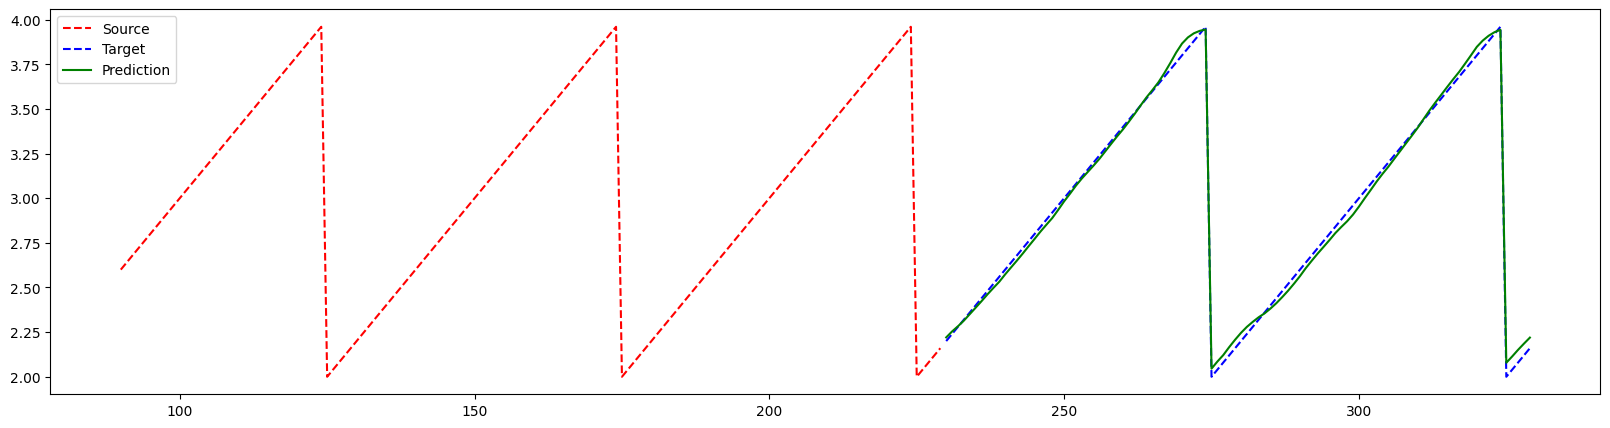

In [141]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [142]:
inspect_step = 0

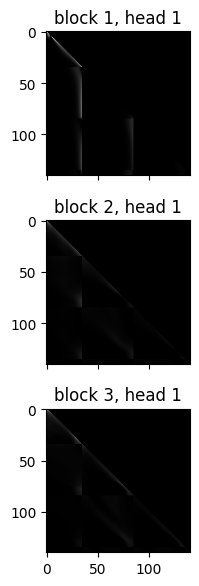

In [143]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

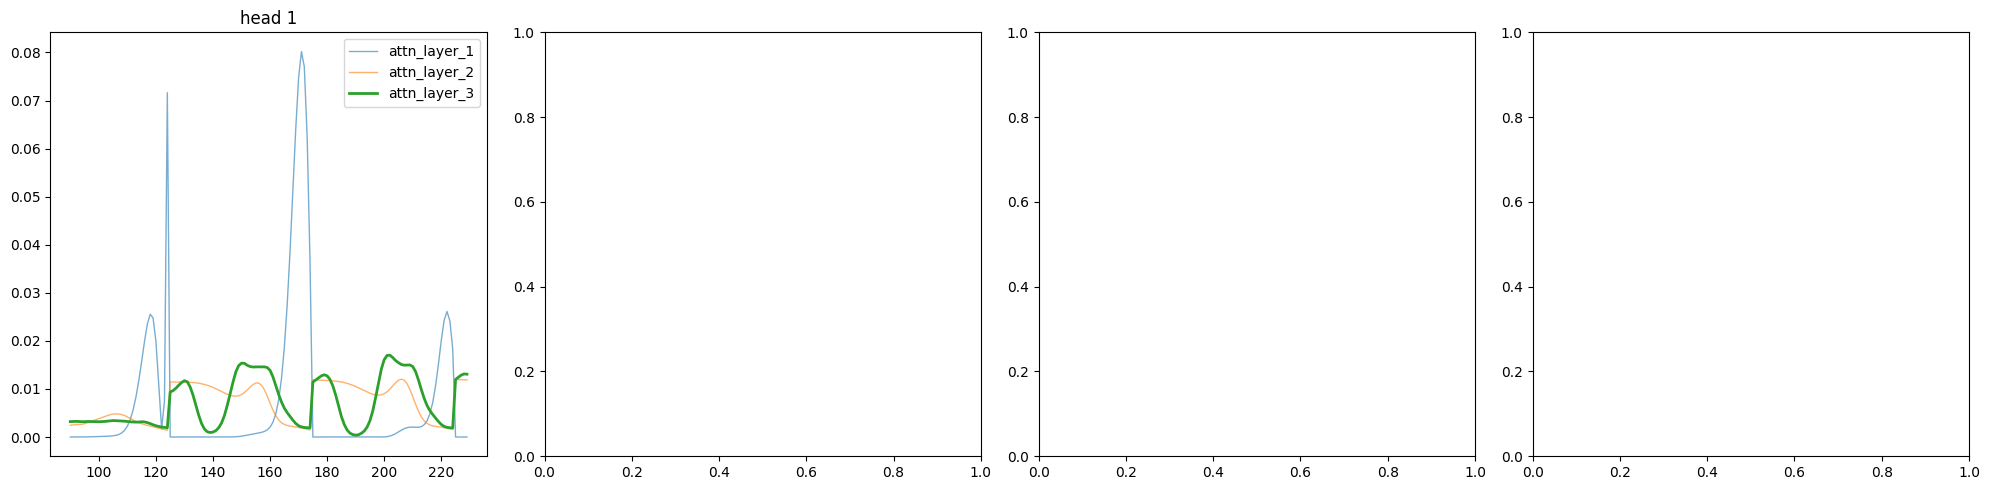

In [144]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

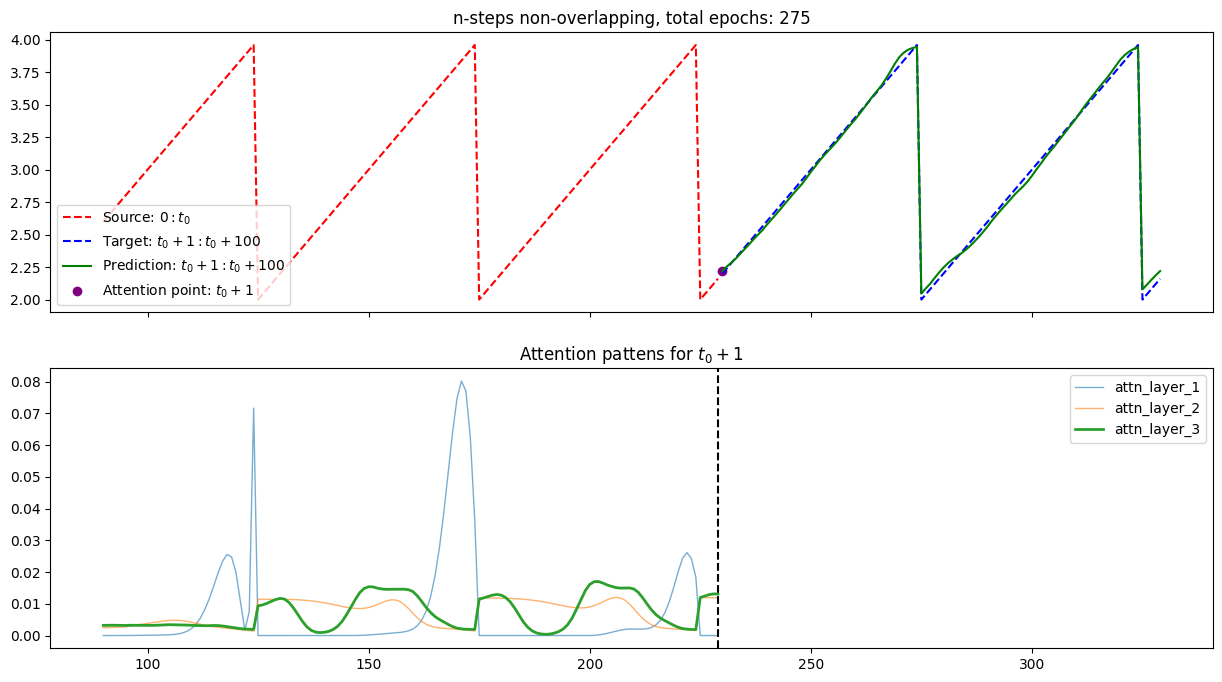

In [145]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sawtooth function

In [146]:
DATASET_NAME = "sawtooth_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

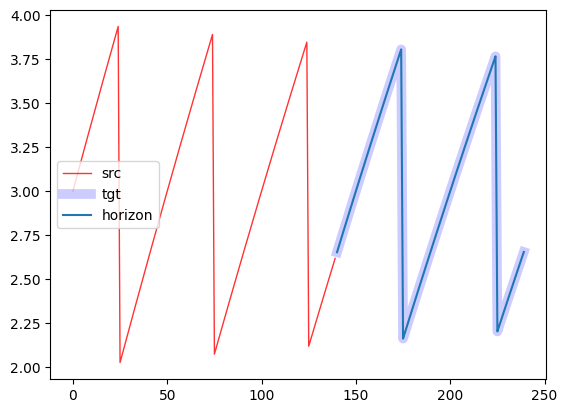

In [147]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [148]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [149]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.3767	val_loss=0.0342	train_mape_loss=0.1142	val_mape_loss=0.0538	R_p=['0.0528', '0.0157']
epoch=1	train_loss=0.0473	val_loss=0.0175	train_mape_loss=0.0555	val_mape_loss=0.0296	R_p=['0.0290', '0.0154']
epoch=2	train_loss=0.0409	val_loss=0.0157	train_mape_loss=0.0510	val_mape_loss=0.0242	R_p=['0.0237', '0.0165']
epoch=3	train_loss=0.0386	val_loss=0.0157	train_mape_loss=0.0491	val_mape_loss=0.0241	R_p=['0.0236', '0.0165']
epoch=4	train_loss=0.0372	val_loss=0.0150	train_mape_loss=0.0480	val_mape_loss=0.0203	R_p=['0.0200', '0.0198']
epoch=5	train_loss=0.0366	val_loss=0.0150	train_mape_loss=0.0475	val_mape_loss=0.0207	R_p=['0.0204', '0.0214']
epoch=6	train_loss=0.0364	val_loss=0.0150	train_mape_loss=0.0474	val_mape_loss=0.0203	R_p=['0.0200', '0.0191']
epoch=7	train_loss=0.0362	val_loss=0.0151	train_mape_loss=0.0472	val_mape_loss=0.0211	R_p=['0.0207', '0.0180']
epoch=8	train_loss=0.0360	val_loss=0.0150	train_mape_loss=0.0470	val_mape_loss=0.0214	R_p=['0.0211', '0.0236']
e

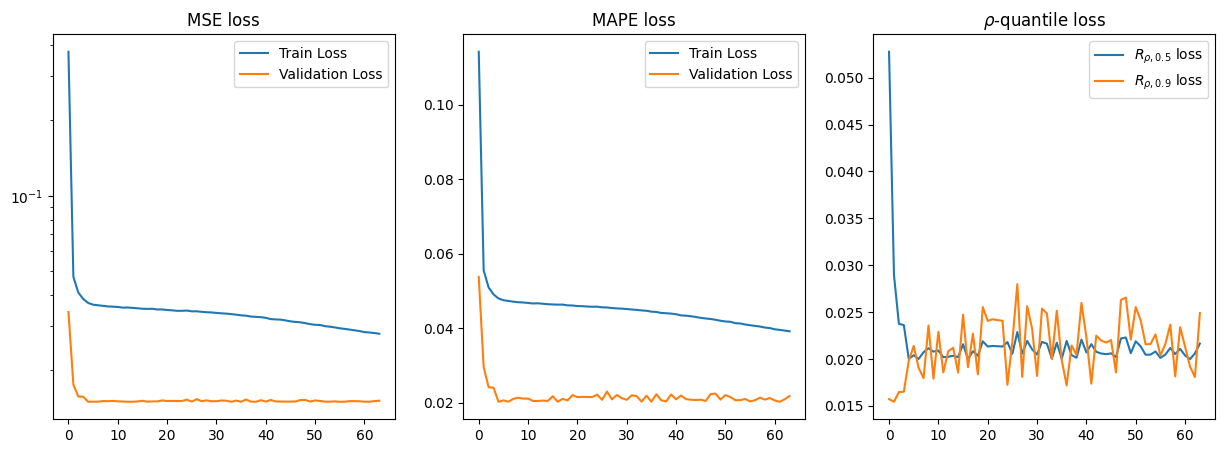

In [150]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [151]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.02015484684705734,
 0.025444553643465043,
 [0.025118673220276833, 0.028270207345485687])

In [152]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [153]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.02001564157009125,
 0.024081154197454453,
 tensor([0.0237, 0.0235], device='cuda:0'))

#### Predict

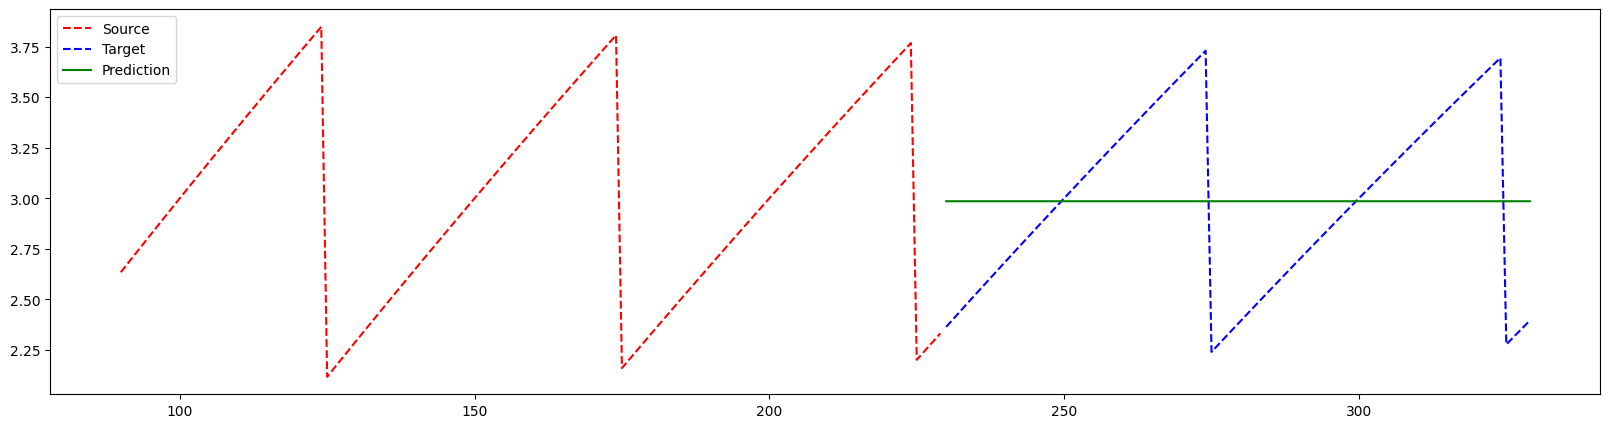

In [154]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [155]:
inspect_step = 0

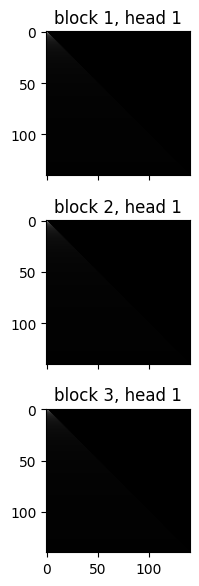

In [156]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

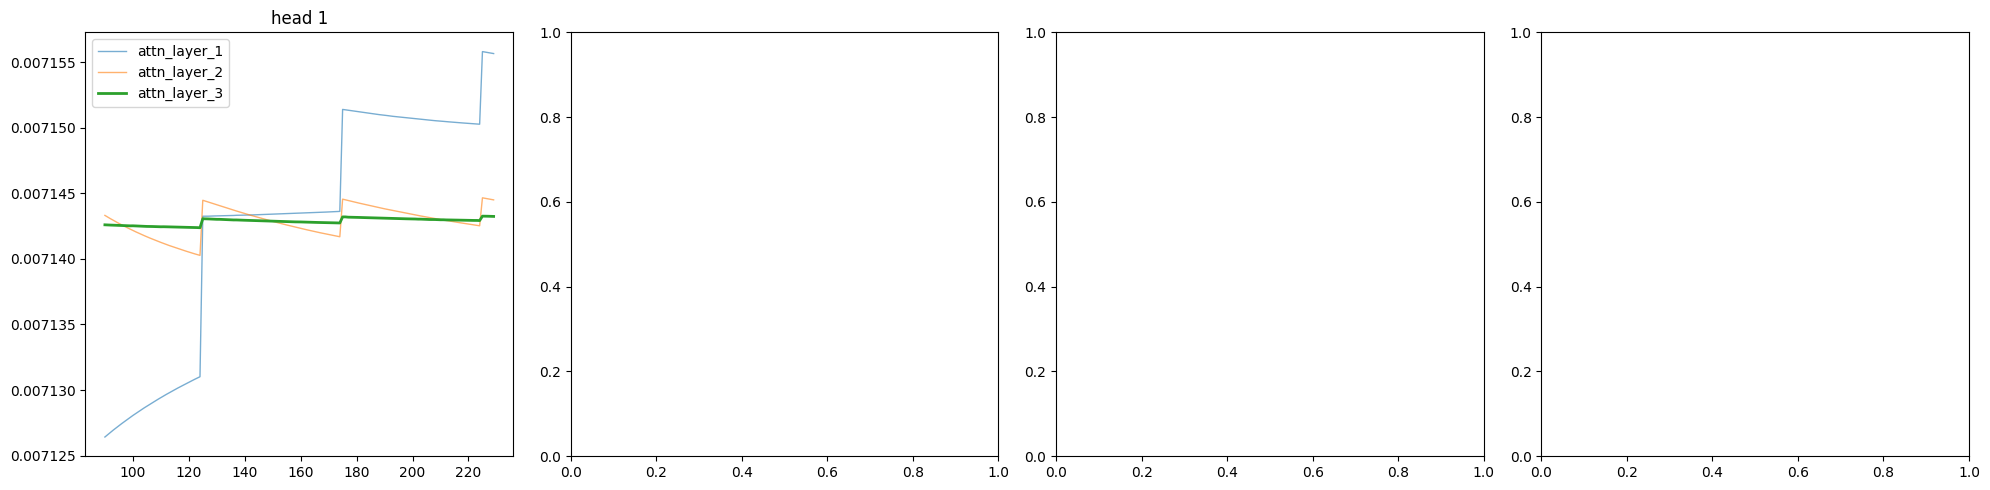

In [157]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

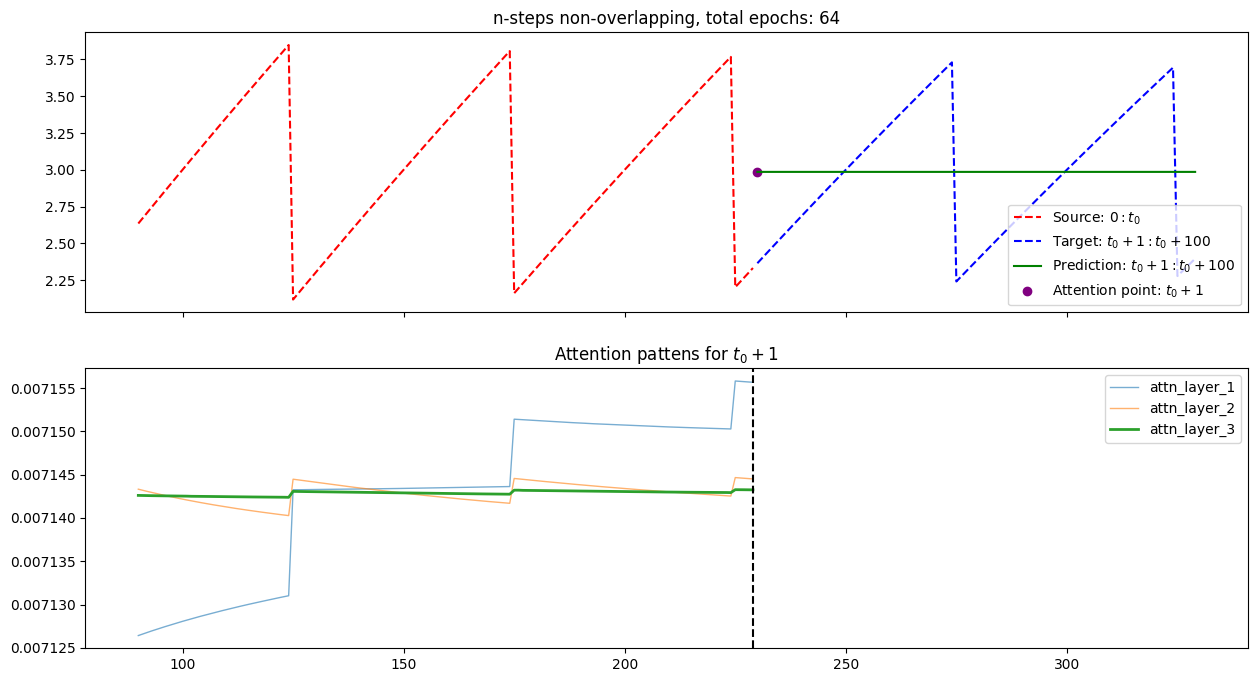

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sawtooth function

In [159]:
DATASET_NAME = "sawtooth_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

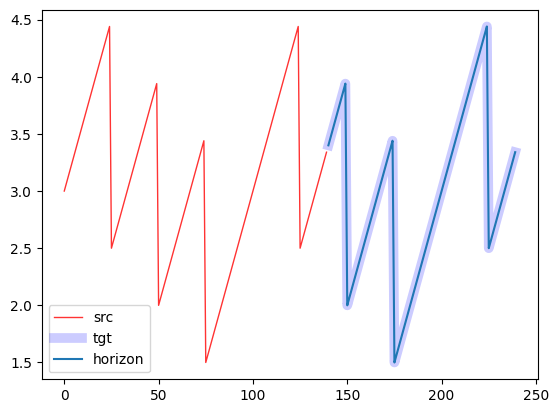

In [160]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [161]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [162]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.6447	val_loss=0.5186	train_mape_loss=0.2408	val_mape_loss=0.2328	R_p=['0.1995', '0.1625']
epoch=1	train_loss=0.5212	val_loss=0.5015	train_mape_loss=0.2227	val_mape_loss=0.2229	R_p=['0.1967', '0.1852']
epoch=2	train_loss=0.5185	val_loss=0.5001	train_mape_loss=0.2223	val_mape_loss=0.2211	R_p=['0.1964', '0.1908']
epoch=3	train_loss=0.5178	val_loss=0.4999	train_mape_loss=0.2221	val_mape_loss=0.2205	R_p=['0.1964', '0.1927']
epoch=4	train_loss=0.5165	val_loss=0.5000	train_mape_loss=0.2220	val_mape_loss=0.2208	R_p=['0.1964', '0.1916']
epoch=5	train_loss=0.5160	val_loss=0.5000	train_mape_loss=0.2218	val_mape_loss=0.2209	R_p=['0.1964', '0.1913']
epoch=6	train_loss=0.5158	val_loss=0.4999	train_mape_loss=0.2218	val_mape_loss=0.2206	R_p=['0.1964', '0.1923']
epoch=7	train_loss=0.5155	val_loss=0.5003	train_mape_loss=0.2217	val_mape_loss=0.2214	R_p=['0.1965', '0.1899']
epoch=8	train_loss=0.5150	val_loss=0.5001	train_mape_loss=0.2217	val_mape_loss=0.2210	R_p=['0.1964', '0.1911']
e

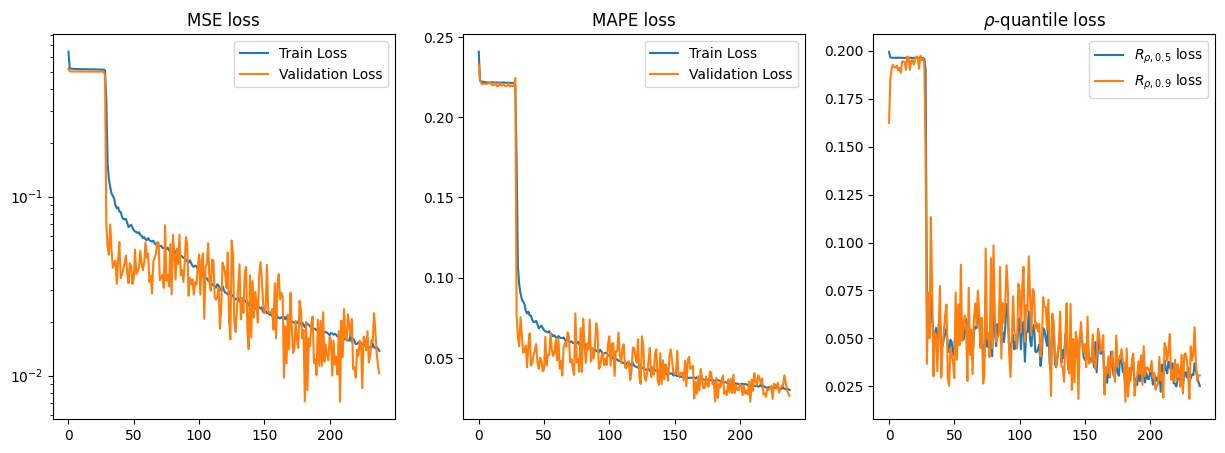

In [163]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [164]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.010111718632280827,
 0.026393059834837914,
 [0.025520432740449905, 0.02668869122862816])

In [165]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [166]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.006898200944066048,
 0.02216200965642929,
 tensor([0.0217, 0.0246], device='cuda:0'))

#### Predict

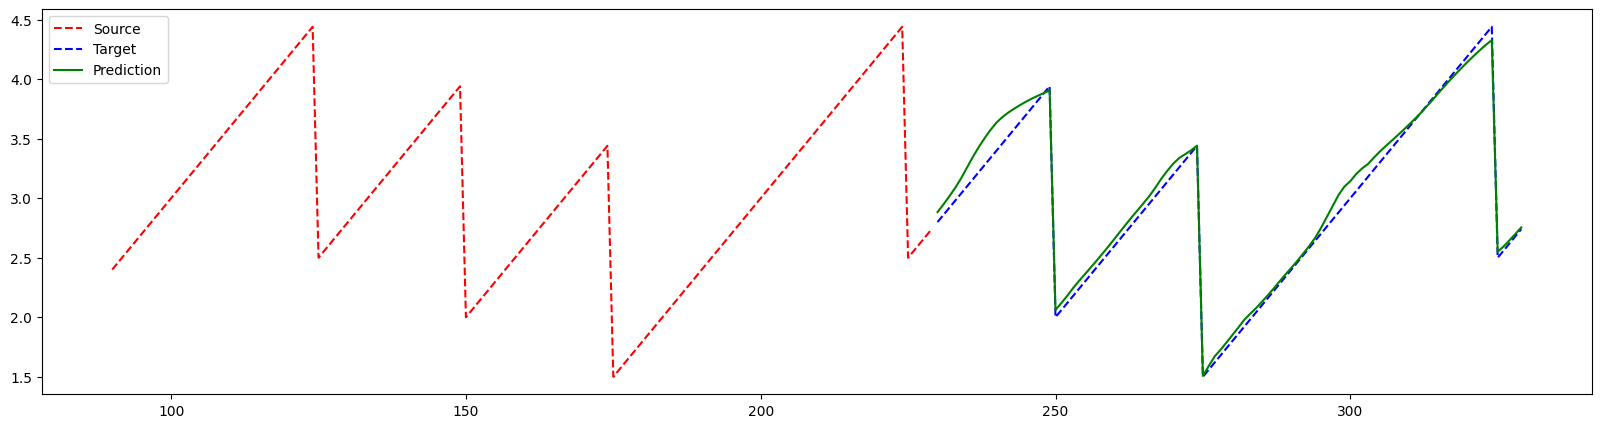

In [167]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [168]:
inspect_step = 0

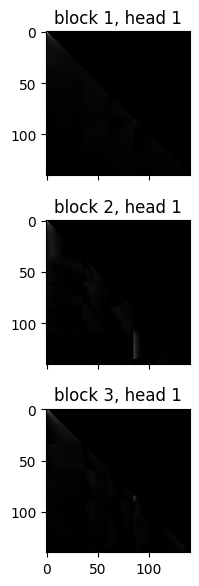

In [169]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

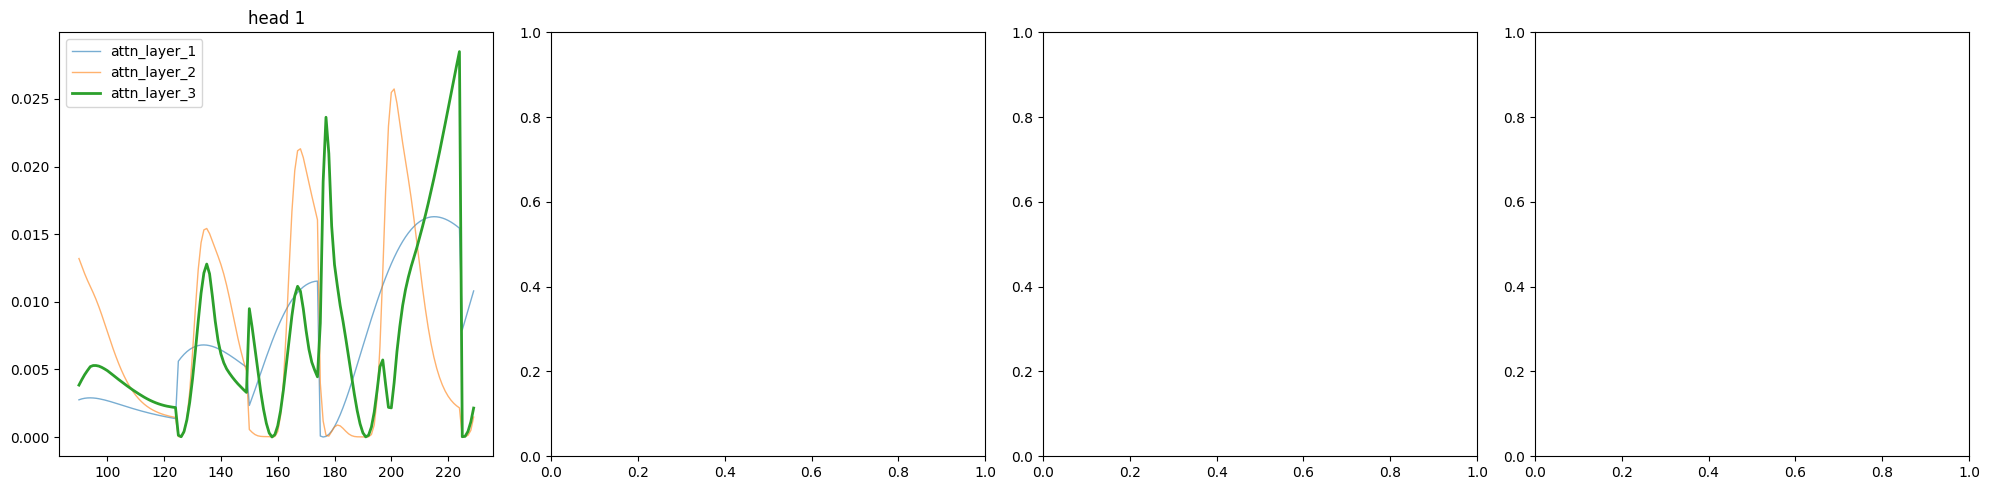

In [170]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

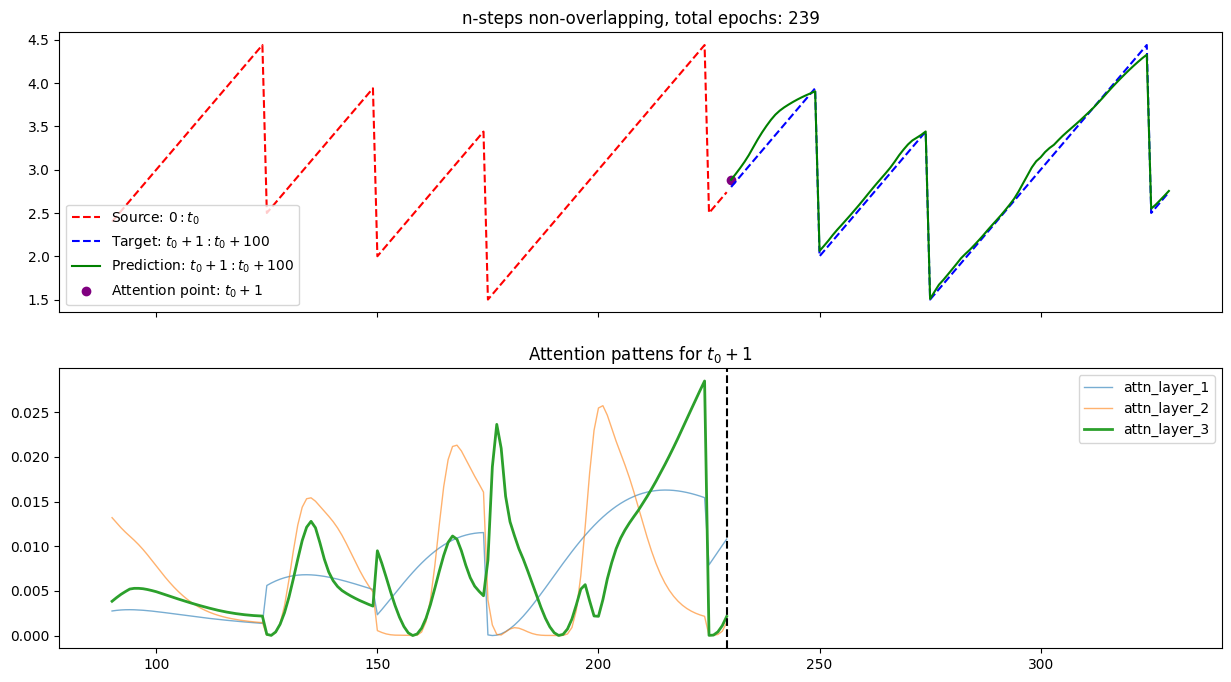

In [171]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)